# Quickstart Example of Advanced Off-Policy Evaluation and Selection (continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from syntheticgym import SyntheticEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this Synthetic problem as the following Constrained Markov Decision Process (CMDP):
- `state`: 
- `action`: 
- `reward`: 

<!-- For more about the environmental configuration and its customization, please refer to [examples/quickstart/synthetic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_customize_env.ipynb). -->

In [9]:
# standardized environment for continuous action
# env = gym.make("SyntheticEnv-continuous-v0")
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

For more about the data collection and visualization, please refer to [examples/quickstart/synthetic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        # minimum=0.1,   # 0.1
        # maximum=10,  # 10
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)

2023-03-10 11:12.42 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230310111242
2023-03-10 11:12.42 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-10 11:12.42 [debug    ] Building model...
2023-03-10 11:12.42 [debug    ] Model has been built.
2023-03-10 11:12.42 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230310111242/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:12.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310111242/model_100.pt
2023-03-10 11:12.42 [info     ] SAC_online_20230310111242: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0005997395515441894, 'time_environment_step': 2.4769306182861328e-05, 'time_step': 0.0006398653984069824, 'rollout_return': 26.34304901356922, 'evaluation': 27.331837049021544} step=100
2023-03-10 11:12.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310111242/model_200.pt
2023-03-10 11:12.42 [info     ] SAC_online_20230310111242: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.0002461886405944824, 'time_environment_step': 1.722574234008789e-05, 'time_step': 0.00027338027954101565, 'rollout_return': 28.99390091366802, 'evaluation': 27.535145751302856} step=200
2023-03-10 11:12.43 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230310111242/model_300.pt
2023-03-10 11:12.43 [info     ] SAC_online_20230310111242: epoc

In [13]:
# save model
sac.save_model("d3rlpy_logs/synthetic_sac.pt")

In [14]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/synthetic_sac.pt")

2023-03-10 11:13.16 [warning  ] Parameters will be reinitialized.


In [15]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [16]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [19]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb).

In [20]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [21]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [22]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [23]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 11:36.28 [debug    ] RandomIterator is selected.
2023-03-10 11:36.28 [info     ] Directory is created at d3rlpy_logs/CQL_20230310113628
2023-03-10 11:36.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:36.28 [debug    ] Building models...
2023-03-10 11:36.28 [debug    ] Models have been built.
2023-03-10 11:36.28 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310113628/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:38.35 [info     ] CQL_20230310113628: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000493644380569458, 'time_algorithm_update': 0.01179490716457367, 'temp_loss': -0.6006174782076851, 'temp': 1.3193697269916533, 'alpha_loss': 3.269989456248074, 'alpha': 0.7316326381295919, 'critic_loss': 577.1039474516392, 'actor_loss': -49.717068636405465, 'time_step': 0.012637632894515992} step=10000
2023-03-10 11:38.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310113628/model_10000.pt
2023-03-10 11:38.35 [debug    ] RandomIterator is selected.
2023-03-10 11:38.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230310113835
2023-03-10 11:38.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:38.35 [debug    ] Building models...
2023-03-10 11:38.35 [debug    ] Models have been built.
2023-03-10 11:38.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310113835/params.json params={'action_scaler': {'type': 'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:40.38 [info     ] CQL_20230310113835: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005092174291610718, 'time_algorithm_update': 0.011406534862518311, 'temp_loss': -0.6221579284725711, 'temp': 1.2924269881665706, 'alpha_loss': 2.3198488071116152, 'alpha': 0.7657960020214319, 'critic_loss': 597.7494013675213, 'actor_loss': -51.157804679858685, 'time_step': 0.012278957009315491} step=10000
2023-03-10 11:40.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310113835/model_10000.pt
2023-03-10 11:40.38 [debug    ] RandomIterator is selected.
2023-03-10 11:40.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230310114038
2023-03-10 11:40.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:40.38 [debug    ] Building models...
2023-03-10 11:40.38 [debug    ] Models have been built.
2023-03-10 11:40.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310114038/params.json params={'action_scaler': {'type': '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:42.34 [info     ] CQL_20230310114038: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004957045316696167, 'time_algorithm_update': 0.010690478825569153, 'temp_loss': -0.5677642425701953, 'temp': 1.2954074643731117, 'alpha_loss': 2.9306758039107548, 'alpha': 0.7446921916037798, 'critic_loss': 567.2897225286007, 'actor_loss': -49.216957411956784, 'time_step': 0.01154261817932129} step=10000
2023-03-10 11:42.34 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310114038/model_10000.pt
2023-03-10 11:42.34 [debug    ] RandomIterator is selected.
2023-03-10 11:42.34 [info     ] Directory is created at d3rlpy_logs/IQL_20230310114234
2023-03-10 11:42.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:42.34 [debug    ] Building models...
2023-03-10 11:42.34 [debug    ] Models have been built.
2023-03-10 11:42.34 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310114234/params.json params={'action_scaler': {'type': 'm

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:43.10 [info     ] IQL_20230310114234: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047728283405303957, 'time_algorithm_update': 0.0028608696460723877, 'critic_loss': 275.87100074547527, 'value_loss': 0.629580480743334, 'actor_loss': -40.25119451257847, 'time_step': 0.0035072125673294065} step=10000
2023-03-10 11:43.10 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310114234/model_10000.pt
2023-03-10 11:43.10 [debug    ] RandomIterator is selected.
2023-03-10 11:43.10 [info     ] Directory is created at d3rlpy_logs/IQL_20230310114310
2023-03-10 11:43.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:43.10 [debug    ] Building models...
2023-03-10 11:43.10 [debug    ] Models have been built.
2023-03-10 11:43.10 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310114310/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:43.43 [info     ] IQL_20230310114310: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047837162017822264, 'time_algorithm_update': 0.002677717924118042, 'critic_loss': 278.04675845479966, 'value_loss': 0.7354895306818289, 'actor_loss': -46.588547363240274, 'time_step': 0.0033288053274154665} step=10000
2023-03-10 11:43.43 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310114310/model_10000.pt
2023-03-10 11:43.43 [debug    ] RandomIterator is selected.
2023-03-10 11:43.43 [info     ] Directory is created at d3rlpy_logs/IQL_20230310114343
2023-03-10 11:43.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:43.43 [debug    ] Building models...
2023-03-10 11:43.43 [debug    ] Models have been built.
2023-03-10 11:43.43 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310114343/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 1

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:44.18 [info     ] IQL_20230310114343: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004769503593444824, 'time_algorithm_update': 0.0027897385120391844, 'critic_loss': 265.48236373651025, 'value_loss': 0.6162714383541233, 'actor_loss': -39.101256537969505, 'time_step': 0.0034343340635299684} step=10000
2023-03-10 11:44.18 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310114343/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 11:44.18 [debug    ] RandomIterator is selected.
2023-03-10 11:44.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230310114418
2023-03-10 11:44.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:44.18 [warning  ] Skip building models since they're already built.
2023-03-10 11:44.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310114418/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:46.27 [info     ] CQL_20230310114418: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004992680549621582, 'time_algorithm_update': 0.0120434415102005, 'temp_loss': 0.058743253265088426, 'temp': 1.4661760466098785, 'alpha_loss': 2.1650318615317343, 'alpha': 0.2938375602021813, 'critic_loss': 482.1724740310669, 'actor_loss': -49.29494075012207, 'time_step': 0.012899490666389466} step=10000
2023-03-10 11:46.27 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310114418/model_10000.pt
2023-03-10 11:46.27 [debug    ] RandomIterator is selected.
2023-03-10 11:46.27 [info     ] Directory is created at d3rlpy_logs/CQL_20230310114627
2023-03-10 11:46.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:46.27 [warning  ] Skip building models since they're already built.
2023-03-10 11:46.27 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310114627/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:48.33 [info     ] CQL_20230310114627: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005155240535736084, 'time_algorithm_update': 0.01159183225631714, 'temp_loss': 0.09417980362507515, 'temp': 1.2542092894792556, 'alpha_loss': 2.360288168120384, 'alpha': 0.3104586167216301, 'critic_loss': 463.39068549041747, 'actor_loss': -49.55556127433777, 'time_step': 0.01247684931755066} step=10000
2023-03-10 11:48.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310114627/model_10000.pt
2023-03-10 11:48.33 [debug    ] RandomIterator is selected.
2023-03-10 11:48.33 [info     ] Directory is created at d3rlpy_logs/CQL_20230310114833
2023-03-10 11:48.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:48.33 [warning  ] Skip building models since they're already built.
2023-03-10 11:48.33 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310114833/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:50.32 [info     ] CQL_20230310114833: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005003293752670288, 'time_algorithm_update': 0.010972582030296326, 'temp_loss': 0.08586156257172115, 'temp': 1.307063726937771, 'alpha_loss': 2.3692710566878317, 'alpha': 0.2976546754926443, 'critic_loss': 426.01987180480955, 'actor_loss': -45.74004949798584, 'time_step': 0.011836985182762145} step=10000
2023-03-10 11:50.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310114833/model_10000.pt
2023-03-10 11:50.32 [debug    ] RandomIterator is selected.
2023-03-10 11:50.32 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115032
2023-03-10 11:50.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:50.32 [warning  ] Skip building models since they're already built.
2023-03-10 11:50.32 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115032/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:51.08 [info     ] IQL_20230310115032: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004755018711090088, 'time_algorithm_update': 0.0029164405822753904, 'critic_loss': 300.98101575317384, 'value_loss': 0.3583077036291361, 'actor_loss': -23.42417945923805, 'time_step': 0.0035573213577270507} step=10000
2023-03-10 11:51.08 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115032/model_10000.pt
2023-03-10 11:51.08 [debug    ] RandomIterator is selected.
2023-03-10 11:51.08 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115108
2023-03-10 11:51.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:51.08 [warning  ] Skip building models since they're already built.
2023-03-10 11:51.08 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115108/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:51.40 [info     ] IQL_20230310115108: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004757477521896362, 'time_algorithm_update': 0.00261033673286438, 'critic_loss': 312.08060321884153, 'value_loss': 0.4184943879410625, 'actor_loss': -28.901440585374832, 'time_step': 0.0032537007331848145} step=10000
2023-03-10 11:51.40 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115108/model_10000.pt
2023-03-10 11:51.40 [debug    ] RandomIterator is selected.
2023-03-10 11:51.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115140
2023-03-10 11:51.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:51.40 [warning  ] Skip building models since they're already built.
2023-03-10 11:51.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115140/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:52.15 [info     ] IQL_20230310115140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004741099834442139, 'time_algorithm_update': 0.002820011305809021, 'critic_loss': 318.0770448287964, 'value_loss': 0.32005007508844135, 'actor_loss': -21.47300787205696, 'time_step': 0.003457376551628113} step=10000
2023-03-10 11:52.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115140/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 11:52.15 [debug    ] RandomIterator is selected.
2023-03-10 11:52.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230310115215
2023-03-10 11:52.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:52.15 [warning  ] Skip building models since they're already built.
2023-03-10 11:52.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310115215/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:54.26 [info     ] CQL_20230310115215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005032088041305542, 'time_algorithm_update': 0.012103164672851562, 'temp_loss': 0.7459066504571586, 'temp': 0.7859609977066517, 'alpha_loss': 0.0036724562909887935, 'alpha': 0.17824911765605211, 'critic_loss': 252.82093903656005, 'actor_loss': -40.26196249198914, 'time_step': 0.012968564295768738} step=10000
2023-03-10 11:54.26 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310115215/model_10000.pt
2023-03-10 11:54.26 [debug    ] RandomIterator is selected.
2023-03-10 11:54.26 [info     ] Directory is created at d3rlpy_logs/CQL_20230310115426
2023-03-10 11:54.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:54.26 [warning  ] Skip building models since they're already built.
2023-03-10 11:54.26 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310115426/params.json params={'action_scaler': {'type': 'min_max', 'params': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:56.32 [info     ] CQL_20230310115426: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005130349159240723, 'time_algorithm_update': 0.011654849195480347, 'temp_loss': 0.32371057406291365, 'temp': 0.6433921427369118, 'alpha_loss': 0.12681593827346552, 'alpha': 0.15567934593260288, 'critic_loss': 345.6528519325256, 'actor_loss': -45.8776412361145, 'time_step': 0.012536735749244689} step=10000
2023-03-10 11:56.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310115426/model_10000.pt
2023-03-10 11:56.32 [debug    ] RandomIterator is selected.
2023-03-10 11:56.32 [info     ] Directory is created at d3rlpy_logs/CQL_20230310115632
2023-03-10 11:56.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:56.32 [warning  ] Skip building models since they're already built.
2023-03-10 11:56.32 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310115632/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:58.31 [info     ] CQL_20230310115632: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005032931327819824, 'time_algorithm_update': 0.010975208592414855, 'temp_loss': 0.536058629873069, 'temp': 0.6667946690022946, 'alpha_loss': 0.11804689375895032, 'alpha': 0.15061110105887054, 'critic_loss': 255.74111893615722, 'actor_loss': -38.12898661460876, 'time_step': 0.011839884448051452} step=10000
2023-03-10 11:58.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310115632/model_10000.pt
2023-03-10 11:58.31 [debug    ] RandomIterator is selected.
2023-03-10 11:58.31 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115831
2023-03-10 11:58.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:58.31 [warning  ] Skip building models since they're already built.
2023-03-10 11:58.31 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115831/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:59.07 [info     ] IQL_20230310115831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047655725479125977, 'time_algorithm_update': 0.0029203823328018187, 'critic_loss': 235.97036482162477, 'value_loss': 0.29504919154047965, 'actor_loss': -8.418278017359972, 'time_step': 0.0035682924032211303} step=10000
2023-03-10 11:59.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115831/model_10000.pt
2023-03-10 11:59.07 [debug    ] RandomIterator is selected.
2023-03-10 11:59.07 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115907
2023-03-10 11:59.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:59.07 [warning  ] Skip building models since they're already built.
2023-03-10 11:59.07 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115907/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_f

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 11:59.40 [info     ] IQL_20230310115907: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004769316911697388, 'time_algorithm_update': 0.0027165879011154174, 'critic_loss': 245.64095095748903, 'value_loss': 0.264746554929018, 'actor_loss': -11.491784240186215, 'time_step': 0.003362938952445984} step=10000
2023-03-10 11:59.40 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115907/model_10000.pt
2023-03-10 11:59.41 [debug    ] RandomIterator is selected.
2023-03-10 11:59.41 [info     ] Directory is created at d3rlpy_logs/IQL_20230310115941
2023-03-10 11:59.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 11:59.41 [warning  ] Skip building models since they're already built.
2023-03-10 11:59.41 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310115941/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:00.16 [info     ] IQL_20230310115941: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047672579288482664, 'time_algorithm_update': 0.0029283606052398683, 'critic_loss': 276.25704579925537, 'value_loss': 0.20360623568110167, 'actor_loss': -8.417752830827236, 'time_step': 0.003577195191383362} step=10000
2023-03-10 12:00.16 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310115941/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 12:00.17 [debug    ] RandomIterator is selected.
2023-03-10 12:00.17 [info     ] Directory is created at d3rlpy_logs/CQL_20230310120017
2023-03-10 12:00.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:00.17 [warning  ] Skip building models since they're already built.
2023-03-10 12:00.17 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310120017/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:02.27 [info     ] CQL_20230310120017: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005043189287185669, 'time_algorithm_update': 0.012080299234390258, 'temp_loss': 0.002120235589379445, 'temp': 0.517401511067152, 'alpha_loss': -0.15547011674960123, 'alpha': 0.2257184626057744, 'critic_loss': 317.1752540100098, 'actor_loss': -46.48779942054748, 'time_step': 0.012954209351539611} step=10000
2023-03-10 12:02.27 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310120017/model_10000.pt
2023-03-10 12:02.27 [debug    ] RandomIterator is selected.
2023-03-10 12:02.27 [info     ] Directory is created at d3rlpy_logs/CQL_20230310120227
2023-03-10 12:02.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:02.27 [warning  ] Skip building models since they're already built.
2023-03-10 12:02.27 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310120227/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:04.33 [info     ] CQL_20230310120227: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005148962020874023, 'time_algorithm_update': 0.01167818558216095, 'temp_loss': 0.023791769371693954, 'temp': 0.34354361154437063, 'alpha_loss': 0.01577456985279805, 'alpha': 0.09642602945119143, 'critic_loss': 270.9628738571167, 'actor_loss': -42.90537475128174, 'time_step': 0.01257467119693756} step=10000
2023-03-10 12:04.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310120227/model_10000.pt
2023-03-10 12:04.33 [debug    ] RandomIterator is selected.
2023-03-10 12:04.33 [info     ] Directory is created at d3rlpy_logs/CQL_20230310120433
2023-03-10 12:04.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:04.33 [warning  ] Skip building models since they're already built.
2023-03-10 12:04.33 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310120433/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:06.35 [info     ] CQL_20230310120433: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005060961723327637, 'time_algorithm_update': 0.011229092121124268, 'temp_loss': 0.06680430163703859, 'temp': 0.31597592320740225, 'alpha_loss': 0.04233653404428278, 'alpha': 0.07497127852216363, 'critic_loss': 215.3496195907593, 'actor_loss': -36.339085190582274, 'time_step': 0.012108112716674805} step=10000
2023-03-10 12:06.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310120433/model_10000.pt
2023-03-10 12:06.35 [debug    ] RandomIterator is selected.
2023-03-10 12:06.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230310120635
2023-03-10 12:06.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:06.35 [warning  ] Skip building models since they're already built.
2023-03-10 12:06.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310120635/params.json params={'action_scaler': {'type': 'min_max', 'params': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:07.10 [info     ] IQL_20230310120635: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004733621120452881, 'time_algorithm_update': 0.0028258564233779905, 'critic_loss': 211.0205588859558, 'value_loss': 0.24968989521563054, 'actor_loss': -7.673118487338722, 'time_step': 0.003467256259918213} step=10000
2023-03-10 12:07.10 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310120635/model_10000.pt
2023-03-10 12:07.10 [debug    ] RandomIterator is selected.
2023-03-10 12:07.10 [info     ] Directory is created at d3rlpy_logs/IQL_20230310120710
2023-03-10 12:07.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:07.10 [warning  ] Skip building models since they're already built.
2023-03-10 12:07.10 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310120710/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fact

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:07.44 [info     ] IQL_20230310120710: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004744841814041138, 'time_algorithm_update': 0.0027398597955703733, 'critic_loss': 225.13567367019652, 'value_loss': 0.16921406158208846, 'actor_loss': -6.181144926667214, 'time_step': 0.0033828995943069456} step=10000
2023-03-10 12:07.44 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310120710/model_10000.pt
2023-03-10 12:07.44 [debug    ] RandomIterator is selected.
2023-03-10 12:07.44 [info     ] Directory is created at d3rlpy_logs/IQL_20230310120744
2023-03-10 12:07.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:07.44 [warning  ] Skip building models since they're already built.
2023-03-10 12:07.44 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310120744/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:08.19 [info     ] IQL_20230310120744: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004724719762802124, 'time_algorithm_update': 0.0028273680925369263, 'critic_loss': 246.2044566925049, 'value_loss': 0.08092717036083341, 'actor_loss': -2.841143848584592, 'time_step': 0.0034633155584335327} step=10000
2023-03-10 12:08.19 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310120744/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 12:08.19 [debug    ] RandomIterator is selected.
2023-03-10 12:08.19 [info     ] Directory is created at d3rlpy_logs/CQL_20230310120819
2023-03-10 12:08.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:08.19 [warning  ] Skip building models since they're already built.
2023-03-10 12:08.19 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310120819/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:10.31 [info     ] CQL_20230310120819: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005020795822143555, 'time_algorithm_update': 0.012256806826591492, 'temp_loss': 0.22493973531589145, 'temp': 0.36793513774573805, 'alpha_loss': -5.160147930788994, 'alpha': 0.6398472438961268, 'critic_loss': 427.5796758117676, 'actor_loss': -51.597238257980344, 'time_step': 0.01312209906578064} step=10000
2023-03-10 12:10.31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310120819/model_10000.pt
2023-03-10 12:10.31 [debug    ] RandomIterator is selected.
2023-03-10 12:10.31 [info     ] Directory is created at d3rlpy_logs/CQL_20230310121031
2023-03-10 12:10.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:10.31 [warning  ] Skip building models since they're already built.
2023-03-10 12:10.31 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310121031/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:12.38 [info     ] CQL_20230310121031: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005149779081344604, 'time_algorithm_update': 0.011801509976387023, 'temp_loss': 0.027504528756719084, 'temp': 0.296097048766911, 'alpha_loss': -2.3340012401401995, 'alpha': 0.18957999672964215, 'critic_loss': 523.5695071716309, 'actor_loss': -57.950828396987916, 'time_step': 0.012692723941802979} step=10000
2023-03-10 12:12.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310121031/model_10000.pt
2023-03-10 12:12.38 [debug    ] RandomIterator is selected.
2023-03-10 12:12.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230310121238
2023-03-10 12:12.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:12.38 [warning  ] Skip building models since they're already built.
2023-03-10 12:12.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310121238/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:14.40 [info     ] CQL_20230310121238: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005052567005157471, 'time_algorithm_update': 0.01120544981956482, 'temp_loss': 0.10151420655272086, 'temp': 0.17506426386386156, 'alpha_loss': -0.6700048959493637, 'alpha': 0.0982759183190763, 'critic_loss': 252.67721450119018, 'actor_loss': -39.56363486480713, 'time_step': 0.012079997611045837} step=10000
2023-03-10 12:14.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310121238/model_10000.pt
2023-03-10 12:14.40 [debug    ] RandomIterator is selected.
2023-03-10 12:14.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230310121440
2023-03-10 12:14.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:14.40 [warning  ] Skip building models since they're already built.
2023-03-10 12:14.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310121440/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:15.15 [info     ] IQL_20230310121440: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047664189338684083, 'time_algorithm_update': 0.0028750789165496826, 'critic_loss': 193.0901153076172, 'value_loss': 0.5351748456686735, 'actor_loss': -3.2395439934890717, 'time_step': 0.003527422571182251} step=10000
2023-03-10 12:15.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310121440/model_10000.pt
2023-03-10 12:15.15 [debug    ] RandomIterator is selected.
2023-03-10 12:15.15 [info     ] Directory is created at d3rlpy_logs/IQL_20230310121515
2023-03-10 12:15.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:15.15 [warning  ] Skip building models since they're already built.
2023-03-10 12:15.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310121515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:15.48 [info     ] IQL_20230310121515: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00048241002559661864, 'time_algorithm_update': 0.0026146353721618653, 'critic_loss': 209.97706903533935, 'value_loss': 0.500710170480609, 'actor_loss': -0.7548606988161802, 'time_step': 0.0032916913986206055} step=10000
2023-03-10 12:15.48 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310121515/model_10000.pt
2023-03-10 12:15.48 [debug    ] RandomIterator is selected.
2023-03-10 12:15.48 [info     ] Directory is created at d3rlpy_logs/IQL_20230310121548
2023-03-10 12:15.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:15.48 [warning  ] Skip building models since they're already built.
2023-03-10 12:15.48 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310121548/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:16.24 [info     ] IQL_20230310121548: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047578349113464356, 'time_algorithm_update': 0.0029103379487991333, 'critic_loss': 209.55603911972045, 'value_loss': 0.3073124230518937, 'actor_loss': -2.9009960380366073, 'time_step': 0.00355685932636261} step=10000
2023-03-10 12:16.24 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310121548/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-10 12:16.24 [debug    ] RandomIterator is selected.
2023-03-10 12:16.24 [info     ] Directory is created at d3rlpy_logs/CQL_20230310121624
2023-03-10 12:16.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:16.24 [warning  ] Skip building models since they're already built.
2023-03-10 12:16.24 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310121624/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:18.35 [info     ] CQL_20230310121624: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005021259307861328, 'time_algorithm_update': 0.012163271164894103, 'temp_loss': 0.014463232729042647, 'temp': 0.21184993025362492, 'alpha_loss': -8.794415746355057, 'alpha': 1.8270394320368766, 'critic_loss': 316.1264800491333, 'actor_loss': -44.490849817276, 'time_step': 0.01303523988723755} step=10000
2023-03-10 12:18.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310121624/model_10000.pt
2023-03-10 12:18.35 [debug    ] RandomIterator is selected.
2023-03-10 12:18.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230310121835
2023-03-10 12:18.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:18.35 [warning  ] Skip building models since they're already built.
2023-03-10 12:18.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310121835/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:20.41 [info     ] CQL_20230310121835: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000516936993598938, 'time_algorithm_update': 0.011617600512504577, 'temp_loss': 0.0036172749668709004, 'temp': 0.2344020501151681, 'alpha_loss': -4.25481201877594, 'alpha': 0.5475783387571573, 'critic_loss': 436.93483557128906, 'actor_loss': -52.82819941825867, 'time_step': 0.012523886394500732} step=10000
2023-03-10 12:20.41 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310121835/model_10000.pt
2023-03-10 12:20.41 [debug    ] RandomIterator is selected.
2023-03-10 12:20.41 [info     ] Directory is created at d3rlpy_logs/CQL_20230310122041
2023-03-10 12:20.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:20.41 [warning  ] Skip building models since they're already built.
2023-03-10 12:20.41 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230310122041/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:22.40 [info     ] CQL_20230310122041: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000506022334098816, 'time_algorithm_update': 0.010906477499008178, 'temp_loss': -0.00308443430881598, 'temp': 0.1484995053321123, 'alpha_loss': -1.6750001244068147, 'alpha': 0.29131617666482923, 'critic_loss': 260.4900418640137, 'actor_loss': -40.03532823104858, 'time_step': 0.011795607423782349} step=10000
2023-03-10 12:22.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230310122041/model_10000.pt
2023-03-10 12:22.40 [debug    ] RandomIterator is selected.
2023-03-10 12:22.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230310122240
2023-03-10 12:22.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:22.40 [warning  ] Skip building models since they're already built.
2023-03-10 12:22.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310122240/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:23.15 [info     ] IQL_20230310122240: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004749370574951172, 'time_algorithm_update': 0.0028119452238082885, 'critic_loss': 185.63528326568604, 'value_loss': 0.4160457654953003, 'actor_loss': -3.5958189283575863, 'time_step': 0.0034532742977142336} step=10000
2023-03-10 12:23.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310122240/model_10000.pt
2023-03-10 12:23.15 [debug    ] RandomIterator is selected.
2023-03-10 12:23.15 [info     ] Directory is created at d3rlpy_logs/IQL_20230310122315
2023-03-10 12:23.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:23.15 [warning  ] Skip building models since they're already built.
2023-03-10 12:23.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310122315/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:23.48 [info     ] IQL_20230310122315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004757290840148926, 'time_algorithm_update': 0.0026381481409072875, 'critic_loss': 203.6762276802063, 'value_loss': 0.480924953609705, 'actor_loss': -1.9788560529153794, 'time_step': 0.003283523917198181} step=10000
2023-03-10 12:23.48 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310122315/model_10000.pt
2023-03-10 12:23.48 [debug    ] RandomIterator is selected.
2023-03-10 12:23.48 [info     ] Directory is created at d3rlpy_logs/IQL_20230310122348
2023-03-10 12:23.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:23.48 [warning  ] Skip building models since they're already built.
2023-03-10 12:23.48 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230310122348/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-10 12:24.23 [info     ] IQL_20230310122348: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004724588871002197, 'time_algorithm_update': 0.0028452272176742554, 'critic_loss': 201.0211055770874, 'value_loss': 0.29898044783174993, 'actor_loss': -3.0251973175052553, 'time_step': 0.0034831127166748046} step=10000
2023-03-10 12:24.23 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230310122348/model_10000.pt


In [24]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [25]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [26]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [27]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [28]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [29]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [30]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [31]:
test_logged_dataset.behavior_policy_names

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']

In [32]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    path="synthetic/input_dict/",
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:41.27 [debug    ] RoundIterator is selected.
2023-03-10 12:41.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124127
2023-03-10 12:41.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.27 [debug    ] Building models...
2023-03-10 12:41.27 [debug    ] Models have been built.
2023-03-10 12:41.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124127/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.28 [info     ] FQE_20230310124127: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.132623672485352e-05, 'time_algorithm_update': 0.0008626461029052734, 'loss': 402.20002155303956, 'time_step': 0.0009887700080871583} step=1000
2023-03-10 12:41.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124127/model_1000.pt
2023-03-10 12:41.28 [debug    ] RoundIterator is selected.
2023-03-10 12:41.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124128
2023-03-10 12:41.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.28 [debug    ] Building models...
2023-03-10 12:41.28 [debug    ] Models have been built.
2023-03-10 12:41.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124128/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.29 [info     ] FQE_20230310124128: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.648634910583496e-05, 'time_algorithm_update': 0.0007994952201843262, 'loss': 358.7148455429077, 'time_step': 0.0009063968658447266} step=1000
2023-03-10 12:41.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124128/model_1000.pt
2023-03-10 12:41.29 [debug    ] RoundIterator is selected.
2023-03-10 12:41.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124129
2023-03-10 12:41.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.29 [debug    ] Building models...
2023-03-10 12:41.29 [debug    ] Models have been built.
2023-03-10 12:41.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124129/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.30 [info     ] FQE_20230310124129: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.481980323791504e-05, 'time_algorithm_update': 0.0007680010795593262, 'loss': 205.03355351257323, 'time_step': 0.0008721828460693359} step=1000
2023-03-10 12:41.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124129/model_1000.pt
2023-03-10 12:41.30 [debug    ] RoundIterator is selected.
2023-03-10 12:41.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124130
2023-03-10 12:41.30 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.30 [debug    ] Building models...
2023-03-10 12:41.30 [debug    ] Models have been built.
2023-03-10 12:41.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124130/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.31 [info     ] FQE_20230310124130: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.603073120117188e-05, 'time_algorithm_update': 0.0007794444561004638, 'loss': 618.8776866073608, 'time_step': 0.0008865237236022949} step=1000
2023-03-10 12:41.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124130/model_1000.pt
2023-03-10 12:41.31 [debug    ] RoundIterator is selected.
2023-03-10 12:41.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124131
2023-03-10 12:41.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.31 [debug    ] Building models...
2023-03-10 12:41.31 [debug    ] Models have been built.
2023-03-10 12:41.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124131/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.32 [info     ] FQE_20230310124131: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.596826553344727e-05, 'time_algorithm_update': 0.0007892444133758545, 'loss': 581.6357743301392, 'time_step': 0.0008948571681976318} step=1000
2023-03-10 12:41.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124131/model_1000.pt
2023-03-10 12:41.32 [debug    ] RoundIterator is selected.
2023-03-10 12:41.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124132
2023-03-10 12:41.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.32 [debug    ] Building models...
2023-03-10 12:41.32 [debug    ] Models have been built.
2023-03-10 12:41.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124132/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.33 [info     ] FQE_20230310124132: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.519721984863281e-05, 'time_algorithm_update': 0.0007790055274963379, 'loss': 342.205078874588, 'time_step': 0.0008838820457458496} step=1000
2023-03-10 12:41.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124132/model_1000.pt
2023-03-10 12:41.33 [debug    ] RoundIterator is selected.
2023-03-10 12:41.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124133
2023-03-10 12:41.33 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.33 [debug    ] Building models...
2023-03-10 12:41.33 [debug    ] Models have been built.
2023-03-10 12:41.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124133/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.34 [info     ] FQE_20230310124133: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.421970367431641e-05, 'time_algorithm_update': 0.0007789030075073242, 'loss': 152.297575296402, 'time_step': 0.000882054328918457} step=1000
2023-03-10 12:41.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124133/model_1000.pt
2023-03-10 12:41.34 [debug    ] RoundIterator is selected.
2023-03-10 12:41.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124134
2023-03-10 12:41.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.34 [debug    ] Building models...
2023-03-10 12:41.34 [debug    ] Models have been built.
2023-03-10 12:41.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124134/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.35 [info     ] FQE_20230310124134: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.526564598083496e-05, 'time_algorithm_update': 0.0007837858200073243, 'loss': 551.2246804656983, 'time_step': 0.000888916015625} step=1000
2023-03-10 12:41.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124134/model_1000.pt
2023-03-10 12:41.35 [debug    ] RoundIterator is selected.
2023-03-10 12:41.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124135
2023-03-10 12:41.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.35 [debug    ] Building models...
2023-03-10 12:41.35 [debug    ] Models have been built.
2023-03-10 12:41.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124135/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}},

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.36 [info     ] FQE_20230310124135: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.630705833435059e-05, 'time_algorithm_update': 0.0007737643718719482, 'loss': 199.2621510734558, 'time_step': 0.0008798162937164307} step=1000
2023-03-10 12:41.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124135/model_1000.pt
2023-03-10 12:41.36 [debug    ] RoundIterator is selected.
2023-03-10 12:41.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124136
2023-03-10 12:41.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.36 [debug    ] Building models...
2023-03-10 12:41.36 [debug    ] Models have been built.
2023-03-10 12:41.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124136/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.37 [info     ] FQE_20230310124136: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.572364807128906e-05, 'time_algorithm_update': 0.0007777009010314942, 'loss': 320.1981580715179, 'time_step': 0.0008838801383972168} step=1000
2023-03-10 12:41.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124136/model_1000.pt
2023-03-10 12:41.37 [debug    ] RoundIterator is selected.
2023-03-10 12:41.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124137
2023-03-10 12:41.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.37 [debug    ] Building models...
2023-03-10 12:41.37 [debug    ] Models have been built.
2023-03-10 12:41.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124137/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.38 [info     ] FQE_20230310124137: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.466077804565429e-05, 'time_algorithm_update': 0.00077890944480896, 'loss': 221.22492463493347, 'time_step': 0.0008833620548248291} step=1000
2023-03-10 12:41.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124137/model_1000.pt
2023-03-10 12:41.38 [debug    ] RoundIterator is selected.
2023-03-10 12:41.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124138
2023-03-10 12:41.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.38 [debug    ] Building models...
2023-03-10 12:41.38 [debug    ] Models have been built.
2023-03-10 12:41.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.38 [info     ] FQE_20230310124138: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.469058036804199e-05, 'time_algorithm_update': 0.0007803483009338379, 'loss': 324.3289231414795, 'time_step': 0.0008845946788787842} step=1000
2023-03-10 12:41.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124138/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:41.45 [debug    ] RoundIterator is selected.
2023-03-10 12:41.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124145
2023-03-10 12:41.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.45 [debug    ] Building models...
2023-03-10 12:41.45 [debug    ] Models have been built.
2023-03-10 12:41.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124145/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.46 [info     ] FQE_20230310124145: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.526922225952148e-05, 'time_algorithm_update': 0.0007887852191925049, 'loss': 208.54643583488465, 'time_step': 0.0008933603763580322} step=1000
2023-03-10 12:41.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124145/model_1000.pt
2023-03-10 12:41.46 [debug    ] RoundIterator is selected.
2023-03-10 12:41.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124146
2023-03-10 12:41.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.46 [debug    ] Building models...
2023-03-10 12:41.46 [debug    ] Models have been built.
2023-03-10 12:41.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124146/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.47 [info     ] FQE_20230310124146: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.45377540588379e-05, 'time_algorithm_update': 0.0007916829586029053, 'loss': 269.9016370601654, 'time_step': 0.0008961536884307861} step=1000
2023-03-10 12:41.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124146/model_1000.pt
2023-03-10 12:41.47 [debug    ] RoundIterator is selected.
2023-03-10 12:41.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124147
2023-03-10 12:41.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.47 [debug    ] Building models...
2023-03-10 12:41.47 [debug    ] Models have been built.
2023-03-10 12:41.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124147/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.48 [info     ] FQE_20230310124147: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.482504844665527e-05, 'time_algorithm_update': 0.0007736732959747315, 'loss': 441.43772864723206, 'time_step': 0.0008785703182220459} step=1000
2023-03-10 12:41.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124147/model_1000.pt
2023-03-10 12:41.48 [debug    ] RoundIterator is selected.
2023-03-10 12:41.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124148
2023-03-10 12:41.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.48 [debug    ] Building models...
2023-03-10 12:41.48 [debug    ] Models have been built.
2023-03-10 12:41.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124148/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.49 [info     ] FQE_20230310124148: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.632946968078613e-05, 'time_algorithm_update': 0.0007807259559631347, 'loss': 451.29745598220825, 'time_step': 0.0008877735137939453} step=1000
2023-03-10 12:41.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124148/model_1000.pt
2023-03-10 12:41.49 [debug    ] RoundIterator is selected.
2023-03-10 12:41.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124149
2023-03-10 12:41.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.49 [debug    ] Building models...
2023-03-10 12:41.49 [debug    ] Models have been built.
2023-03-10 12:41.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124149/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.50 [info     ] FQE_20230310124149: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.392001152038574e-05, 'time_algorithm_update': 0.0007754621505737304, 'loss': 233.52879125404357, 'time_step': 0.0008781852722167969} step=1000
2023-03-10 12:41.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124149/model_1000.pt
2023-03-10 12:41.50 [debug    ] RoundIterator is selected.
2023-03-10 12:41.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124150
2023-03-10 12:41.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.50 [debug    ] Building models...
2023-03-10 12:41.50 [debug    ] Models have been built.
2023-03-10 12:41.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124150/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.51 [info     ] FQE_20230310124150: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.432174682617188e-05, 'time_algorithm_update': 0.0007833616733551026, 'loss': 858.1396118392944, 'time_step': 0.0008874020576477051} step=1000
2023-03-10 12:41.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124150/model_1000.pt
2023-03-10 12:41.51 [debug    ] RoundIterator is selected.
2023-03-10 12:41.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124151
2023-03-10 12:41.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.51 [debug    ] Building models...
2023-03-10 12:41.51 [debug    ] Models have been built.
2023-03-10 12:41.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124151/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.52 [info     ] FQE_20230310124151: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.383656501770019e-05, 'time_algorithm_update': 0.0007781698703765869, 'loss': 267.2948551826477, 'time_step': 0.0008814327716827392} step=1000
2023-03-10 12:41.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124151/model_1000.pt
2023-03-10 12:41.52 [debug    ] RoundIterator is selected.
2023-03-10 12:41.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124152
2023-03-10 12:41.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.52 [debug    ] Building models...
2023-03-10 12:41.52 [debug    ] Models have been built.
2023-03-10 12:41.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124152/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.53 [info     ] FQE_20230310124152: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.163762092590332e-05, 'time_algorithm_update': 0.0008537466526031494, 'loss': 440.6224780597687, 'time_step': 0.0009704487323760986} step=1000
2023-03-10 12:41.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124152/model_1000.pt
2023-03-10 12:41.53 [debug    ] RoundIterator is selected.
2023-03-10 12:41.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124153
2023-03-10 12:41.53 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.53 [debug    ] Building models...
2023-03-10 12:41.53 [debug    ] Models have been built.
2023-03-10 12:41.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124153/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.54 [info     ] FQE_20230310124153: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.709598541259765e-05, 'time_algorithm_update': 0.0007903242111206055, 'loss': 264.86375732421874, 'time_step': 0.0008985953330993652} step=1000
2023-03-10 12:41.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124153/model_1000.pt
2023-03-10 12:41.54 [debug    ] RoundIterator is selected.
2023-03-10 12:41.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124154
2023-03-10 12:41.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.54 [debug    ] Building models...
2023-03-10 12:41.54 [debug    ] Models have been built.
2023-03-10 12:41.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124154/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.55 [info     ] FQE_20230310124154: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.400703430175782e-05, 'time_algorithm_update': 0.0007631461620330811, 'loss': 307.89166013908385, 'time_step': 0.0008666269779205322} step=1000
2023-03-10 12:41.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124154/model_1000.pt
2023-03-10 12:41.55 [debug    ] RoundIterator is selected.
2023-03-10 12:41.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124155
2023-03-10 12:41.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.55 [debug    ] Building models...
2023-03-10 12:41.55 [debug    ] Models have been built.
2023-03-10 12:41.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124155/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.56 [info     ] FQE_20230310124155: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.36844539642334e-05, 'time_algorithm_update': 0.0007724225521087647, 'loss': 127.2954727268219, 'time_step': 0.0008748466968536377} step=1000
2023-03-10 12:41.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124155/model_1000.pt
2023-03-10 12:41.56 [debug    ] RoundIterator is selected.
2023-03-10 12:41.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124156
2023-03-10 12:41.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:41.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:41.56 [debug    ] Building models...
2023-03-10 12:41.56 [debug    ] Models have been built.
2023-03-10 12:41.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124156/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:41.56 [info     ] FQE_20230310124156: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.414960861206054e-05, 'time_algorithm_update': 0.0007738847732543945, 'loss': 452.4992901992798, 'time_step': 0.0008772563934326172} step=1000
2023-03-10 12:41.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124156/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:42.03 [debug    ] RoundIterator is selected.
2023-03-10 12:42.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124203
2023-03-10 12:42.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.03 [debug    ] Building models...
2023-03-10 12:42.03 [debug    ] Models have been built.
2023-03-10 12:42.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124203/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.04 [info     ] FQE_20230310124203: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.52251148223877e-05, 'time_algorithm_update': 0.0007898640632629394, 'loss': 610.0496959667206, 'time_step': 0.0008948769569396973} step=1000
2023-03-10 12:42.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124203/model_1000.pt
2023-03-10 12:42.04 [debug    ] RoundIterator is selected.
2023-03-10 12:42.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124204
2023-03-10 12:42.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.04 [debug    ] Building models...
2023-03-10 12:42.04 [debug    ] Models have been built.
2023-03-10 12:42.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124204/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.05 [info     ] FQE_20230310124204: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.489752769470214e-05, 'time_algorithm_update': 0.0007887415885925293, 'loss': 306.4203217754364, 'time_step': 0.0008918657302856445} step=1000
2023-03-10 12:42.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124204/model_1000.pt
2023-03-10 12:42.05 [debug    ] RoundIterator is selected.
2023-03-10 12:42.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124205
2023-03-10 12:42.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.05 [debug    ] Building models...
2023-03-10 12:42.05 [debug    ] Models have been built.
2023-03-10 12:42.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124205/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.06 [info     ] FQE_20230310124205: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.682204246520995e-05, 'time_algorithm_update': 0.0007914717197418212, 'loss': 230.99077729415893, 'time_step': 0.0008995952606201172} step=1000
2023-03-10 12:42.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124205/model_1000.pt
2023-03-10 12:42.06 [debug    ] RoundIterator is selected.
2023-03-10 12:42.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124206
2023-03-10 12:42.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.06 [debug    ] Building models...
2023-03-10 12:42.06 [debug    ] Models have been built.
2023-03-10 12:42.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124206/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.07 [info     ] FQE_20230310124206: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.933783531188965e-05, 'time_algorithm_update': 0.0008176841735839844, 'loss': 422.7884755744934, 'time_step': 0.0009296903610229492} step=1000
2023-03-10 12:42.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124206/model_1000.pt
2023-03-10 12:42.07 [debug    ] RoundIterator is selected.
2023-03-10 12:42.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124207
2023-03-10 12:42.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.07 [debug    ] Building models...
2023-03-10 12:42.07 [debug    ] Models have been built.
2023-03-10 12:42.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124207/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.08 [info     ] FQE_20230310124207: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.639789581298828e-05, 'time_algorithm_update': 0.0007972240447998047, 'loss': 396.3586496734619, 'time_step': 0.0009048233032226562} step=1000
2023-03-10 12:42.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124207/model_1000.pt
2023-03-10 12:42.08 [debug    ] RoundIterator is selected.
2023-03-10 12:42.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124208
2023-03-10 12:42.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.08 [debug    ] Building models...
2023-03-10 12:42.08 [debug    ] Models have been built.
2023-03-10 12:42.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124208/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.09 [info     ] FQE_20230310124208: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.439088821411132e-05, 'time_algorithm_update': 0.0007799808979034423, 'loss': 97.03677025413513, 'time_step': 0.0008835017681121827} step=1000
2023-03-10 12:42.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124208/model_1000.pt
2023-03-10 12:42.09 [debug    ] RoundIterator is selected.
2023-03-10 12:42.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124209
2023-03-10 12:42.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.09 [debug    ] Building models...
2023-03-10 12:42.09 [debug    ] Models have been built.
2023-03-10 12:42.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124209/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.10 [info     ] FQE_20230310124209: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.56375789642334e-05, 'time_algorithm_update': 0.0007912895679473877, 'loss': 400.46702320289614, 'time_step': 0.00089794921875} step=1000
2023-03-10 12:42.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124209/model_1000.pt
2023-03-10 12:42.10 [debug    ] RoundIterator is selected.
2023-03-10 12:42.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124210
2023-03-10 12:42.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.10 [debug    ] Building models...
2023-03-10 12:42.10 [debug    ] Models have been built.
2023-03-10 12:42.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124210/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.11 [info     ] FQE_20230310124210: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.404470443725585e-05, 'time_algorithm_update': 0.0007774283885955811, 'loss': 211.97315146255494, 'time_step': 0.0008801429271697998} step=1000
2023-03-10 12:42.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124210/model_1000.pt
2023-03-10 12:42.11 [debug    ] RoundIterator is selected.
2023-03-10 12:42.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124211
2023-03-10 12:42.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.11 [debug    ] Building models...
2023-03-10 12:42.11 [debug    ] Models have been built.
2023-03-10 12:42.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124211/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.12 [info     ] FQE_20230310124211: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.43095874786377e-05, 'time_algorithm_update': 0.0007614850997924805, 'loss': 269.3011540279388, 'time_step': 0.0008651933670043945} step=1000
2023-03-10 12:42.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124211/model_1000.pt
2023-03-10 12:42.12 [debug    ] RoundIterator is selected.
2023-03-10 12:42.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124212
2023-03-10 12:42.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.12 [debug    ] Building models...
2023-03-10 12:42.12 [debug    ] Models have been built.
2023-03-10 12:42.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124212/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.13 [info     ] FQE_20230310124212: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.405185699462891e-05, 'time_algorithm_update': 0.0007603929042816162, 'loss': 221.3138801574707, 'time_step': 0.0008634784221649169} step=1000
2023-03-10 12:42.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124212/model_1000.pt
2023-03-10 12:42.13 [debug    ] RoundIterator is selected.
2023-03-10 12:42.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124213
2023-03-10 12:42.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.13 [debug    ] Building models...
2023-03-10 12:42.13 [debug    ] Models have been built.
2023-03-10 12:42.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124213/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.13 [info     ] FQE_20230310124213: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.38060474395752e-05, 'time_algorithm_update': 0.0007745730876922608, 'loss': 223.34525332450866, 'time_step': 0.0008776233196258544} step=1000
2023-03-10 12:42.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124213/model_1000.pt
2023-03-10 12:42.13 [debug    ] RoundIterator is selected.
2023-03-10 12:42.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124214
2023-03-10 12:42.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.14 [debug    ] Building models...
2023-03-10 12:42.14 [debug    ] Models have been built.
2023-03-10 12:42.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124214/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.15 [info     ] FQE_20230310124214: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.235478401184082e-05, 'time_algorithm_update': 0.0008642008304595947, 'loss': 195.12471258354188, 'time_step': 0.0009828202724456788} step=1000
2023-03-10 12:42.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124214/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:42.22 [debug    ] RoundIterator is selected.
2023-03-10 12:42.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124222
2023-03-10 12:42.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.22 [debug    ] Building models...
2023-03-10 12:42.22 [debug    ] Models have been built.
2023-03-10 12:42.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124222/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.23 [info     ] FQE_20230310124222: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.684874534606934e-05, 'time_algorithm_update': 0.0007892649173736572, 'loss': 187.22261580467224, 'time_step': 0.0008957412242889404} step=1000
2023-03-10 12:42.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124222/model_1000.pt
2023-03-10 12:42.23 [debug    ] RoundIterator is selected.
2023-03-10 12:42.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124223
2023-03-10 12:42.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.23 [debug    ] Building models...
2023-03-10 12:42.23 [debug    ] Models have been built.
2023-03-10 12:42.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124223/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.24 [info     ] FQE_20230310124223: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.45835304260254e-05, 'time_algorithm_update': 0.0007910888195037842, 'loss': 447.6373897628784, 'time_step': 0.0008956804275512695} step=1000
2023-03-10 12:42.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124223/model_1000.pt
2023-03-10 12:42.24 [debug    ] RoundIterator is selected.
2023-03-10 12:42.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124224
2023-03-10 12:42.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.24 [debug    ] Building models...
2023-03-10 12:42.24 [debug    ] Models have been built.
2023-03-10 12:42.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124224/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.25 [info     ] FQE_20230310124224: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.59439468383789e-05, 'time_algorithm_update': 0.0007827975749969483, 'loss': 545.5240379104614, 'time_step': 0.0008895864486694336} step=1000
2023-03-10 12:42.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124224/model_1000.pt
2023-03-10 12:42.25 [debug    ] RoundIterator is selected.
2023-03-10 12:42.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124225
2023-03-10 12:42.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.25 [debug    ] Building models...
2023-03-10 12:42.25 [debug    ] Models have been built.
2023-03-10 12:42.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124225/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.26 [info     ] FQE_20230310124225: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.427668571472168e-05, 'time_algorithm_update': 0.0007702369689941407, 'loss': 167.66237506294252, 'time_step': 0.0008738331794738769} step=1000
2023-03-10 12:42.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124225/model_1000.pt
2023-03-10 12:42.26 [debug    ] RoundIterator is selected.
2023-03-10 12:42.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124226
2023-03-10 12:42.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.26 [debug    ] Building models...
2023-03-10 12:42.26 [debug    ] Models have been built.
2023-03-10 12:42.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124226/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.27 [info     ] FQE_20230310124226: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.684682846069336e-05, 'time_algorithm_update': 0.0009080069065093994, 'loss': 465.43907892417906, 'time_step': 0.0010324094295501708} step=1000
2023-03-10 12:42.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124226/model_1000.pt
2023-03-10 12:42.27 [debug    ] RoundIterator is selected.
2023-03-10 12:42.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124227
2023-03-10 12:42.27 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.27 [debug    ] Building models...
2023-03-10 12:42.27 [debug    ] Models have been built.
2023-03-10 12:42.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124227/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.28 [info     ] FQE_20230310124227: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.534599304199219e-05, 'time_algorithm_update': 0.0007882263660430909, 'loss': 193.94560002326966, 'time_step': 0.0008935678005218506} step=1000
2023-03-10 12:42.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124227/model_1000.pt
2023-03-10 12:42.28 [debug    ] RoundIterator is selected.
2023-03-10 12:42.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124228
2023-03-10 12:42.28 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.28 [debug    ] Building models...
2023-03-10 12:42.28 [debug    ] Models have been built.
2023-03-10 12:42.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124228/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.29 [info     ] FQE_20230310124228: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.473468780517578e-05, 'time_algorithm_update': 0.0007829055786132813, 'loss': 188.6639916000366, 'time_step': 0.0008870692253112793} step=1000
2023-03-10 12:42.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124228/model_1000.pt
2023-03-10 12:42.29 [debug    ] RoundIterator is selected.
2023-03-10 12:42.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124229
2023-03-10 12:42.29 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.29 [debug    ] Building models...
2023-03-10 12:42.29 [debug    ] Models have been built.
2023-03-10 12:42.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124229/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.30 [info     ] FQE_20230310124229: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.436084747314453e-05, 'time_algorithm_update': 0.0007802650928497314, 'loss': 230.85793168830872, 'time_step': 0.0008838863372802734} step=1000
2023-03-10 12:42.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124229/model_1000.pt
2023-03-10 12:42.30 [debug    ] RoundIterator is selected.
2023-03-10 12:42.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124230
2023-03-10 12:42.30 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.30 [debug    ] Building models...
2023-03-10 12:42.30 [debug    ] Models have been built.
2023-03-10 12:42.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124230/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.31 [info     ] FQE_20230310124230: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.67660140991211e-05, 'time_algorithm_update': 0.0007810714244842529, 'loss': 213.141140001297, 'time_step': 0.0008889029026031495} step=1000
2023-03-10 12:42.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124230/model_1000.pt
2023-03-10 12:42.31 [debug    ] RoundIterator is selected.
2023-03-10 12:42.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124231
2023-03-10 12:42.31 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.31 [debug    ] Building models...
2023-03-10 12:42.31 [debug    ] Models have been built.
2023-03-10 12:42.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124231/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.32 [info     ] FQE_20230310124231: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.286070823669434e-05, 'time_algorithm_update': 0.000843184232711792, 'loss': 205.46694104385375, 'time_step': 0.0009593775272369384} step=1000
2023-03-10 12:42.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124231/model_1000.pt
2023-03-10 12:42.32 [debug    ] RoundIterator is selected.
2023-03-10 12:42.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124232
2023-03-10 12:42.32 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.32 [debug    ] Building models...
2023-03-10 12:42.32 [debug    ] Models have been built.
2023-03-10 12:42.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124232/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.33 [info     ] FQE_20230310124232: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.466530799865722e-05, 'time_algorithm_update': 0.0007790939807891846, 'loss': 439.4392418384552, 'time_step': 0.0008836898803710937} step=1000
2023-03-10 12:42.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124232/model_1000.pt
2023-03-10 12:42.33 [debug    ] RoundIterator is selected.
2023-03-10 12:42.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124233
2023-03-10 12:42.33 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.33 [debug    ] Building models...
2023-03-10 12:42.33 [debug    ] Models have been built.
2023-03-10 12:42.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124233/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.34 [info     ] FQE_20230310124233: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.564568519592285e-05, 'time_algorithm_update': 0.0007876522541046142, 'loss': 410.7469464797974, 'time_step': 0.0008940718173980713} step=1000
2023-03-10 12:42.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124233/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:42.40 [debug    ] RoundIterator is selected.
2023-03-10 12:42.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124240
2023-03-10 12:42.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.40 [debug    ] Building models...
2023-03-10 12:42.40 [debug    ] Models have been built.
2023-03-10 12:42.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124240/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.41 [info     ] FQE_20230310124240: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.585573196411132e-05, 'time_algorithm_update': 0.0007928712368011475, 'loss': 311.4864518451691, 'time_step': 0.0008986611366271972} step=1000
2023-03-10 12:42.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124240/model_1000.pt
2023-03-10 12:42.41 [debug    ] RoundIterator is selected.
2023-03-10 12:42.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124241
2023-03-10 12:42.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.41 [debug    ] Building models...
2023-03-10 12:42.41 [debug    ] Models have been built.
2023-03-10 12:42.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.42 [info     ] FQE_20230310124241: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.597970962524414e-05, 'time_algorithm_update': 0.0008111610412597656, 'loss': 511.53131680107117, 'time_step': 0.0009177546501159668} step=1000
2023-03-10 12:42.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124241/model_1000.pt
2023-03-10 12:42.42 [debug    ] RoundIterator is selected.
2023-03-10 12:42.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124242
2023-03-10 12:42.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.42 [debug    ] Building models...
2023-03-10 12:42.42 [debug    ] Models have been built.
2023-03-10 12:42.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124242/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.43 [info     ] FQE_20230310124242: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.41121768951416e-05, 'time_algorithm_update': 0.0007633121013641358, 'loss': 1819.1197681951523, 'time_step': 0.0008672795295715332} step=1000
2023-03-10 12:42.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124242/model_1000.pt
2023-03-10 12:42.43 [debug    ] RoundIterator is selected.
2023-03-10 12:42.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124243
2023-03-10 12:42.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.43 [debug    ] Building models...
2023-03-10 12:42.43 [debug    ] Models have been built.
2023-03-10 12:42.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124243/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.44 [info     ] FQE_20230310124243: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.501149177551269e-05, 'time_algorithm_update': 0.0007628402709960937, 'loss': 429.65951579666137, 'time_step': 0.0008672864437103272} step=1000
2023-03-10 12:42.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124243/model_1000.pt
2023-03-10 12:42.44 [debug    ] RoundIterator is selected.
2023-03-10 12:42.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124244
2023-03-10 12:42.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.44 [debug    ] Building models...
2023-03-10 12:42.44 [debug    ] Models have been built.
2023-03-10 12:42.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124244/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.45 [info     ] FQE_20230310124244: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.488512992858887e-05, 'time_algorithm_update': 0.0007756774425506592, 'loss': 491.83427929496764, 'time_step': 0.000879941463470459} step=1000
2023-03-10 12:42.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124244/model_1000.pt
2023-03-10 12:42.45 [debug    ] RoundIterator is selected.
2023-03-10 12:42.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124245
2023-03-10 12:42.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.45 [debug    ] Building models...
2023-03-10 12:42.45 [debug    ] Models have been built.
2023-03-10 12:42.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124245/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.46 [info     ] FQE_20230310124245: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.546733856201172e-05, 'time_algorithm_update': 0.0008718805313110351, 'loss': 986.8447292938232, 'time_step': 0.0009939029216766357} step=1000
2023-03-10 12:42.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124245/model_1000.pt
2023-03-10 12:42.46 [debug    ] RoundIterator is selected.
2023-03-10 12:42.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124246
2023-03-10 12:42.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.46 [debug    ] Building models...
2023-03-10 12:42.46 [debug    ] Models have been built.
2023-03-10 12:42.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124246/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.47 [info     ] FQE_20230310124246: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.381463050842285e-05, 'time_algorithm_update': 0.0007741279602050781, 'loss': 277.57739863586426, 'time_step': 0.0008769669532775879} step=1000
2023-03-10 12:42.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124246/model_1000.pt
2023-03-10 12:42.47 [debug    ] RoundIterator is selected.
2023-03-10 12:42.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124247
2023-03-10 12:42.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.47 [debug    ] Building models...
2023-03-10 12:42.47 [debug    ] Models have been built.
2023-03-10 12:42.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124247/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.48 [info     ] FQE_20230310124247: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.494783401489257e-05, 'time_algorithm_update': 0.0007770946025848389, 'loss': 796.1207528629303, 'time_step': 0.0008818514347076416} step=1000
2023-03-10 12:42.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124247/model_1000.pt
2023-03-10 12:42.48 [debug    ] RoundIterator is selected.
2023-03-10 12:42.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124248
2023-03-10 12:42.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.48 [debug    ] Building models...
2023-03-10 12:42.48 [debug    ] Models have been built.
2023-03-10 12:42.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124248/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.49 [info     ] FQE_20230310124248: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.420921325683593e-05, 'time_algorithm_update': 0.0007609837055206299, 'loss': 537.5778649520875, 'time_step': 0.0008649668693542481} step=1000
2023-03-10 12:42.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124248/model_1000.pt
2023-03-10 12:42.49 [debug    ] RoundIterator is selected.
2023-03-10 12:42.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124249
2023-03-10 12:42.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.49 [debug    ] Building models...
2023-03-10 12:42.49 [debug    ] Models have been built.
2023-03-10 12:42.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124249/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.50 [info     ] FQE_20230310124249: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.66596794128418e-05, 'time_algorithm_update': 0.0007692570686340332, 'loss': 365.396477186203, 'time_step': 0.0008765428066253662} step=1000
2023-03-10 12:42.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124249/model_1000.pt
2023-03-10 12:42.50 [debug    ] RoundIterator is selected.
2023-03-10 12:42.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124250
2023-03-10 12:42.50 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.50 [debug    ] Building models...
2023-03-10 12:42.50 [debug    ] Models have been built.
2023-03-10 12:42.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124250/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.51 [info     ] FQE_20230310124250: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.58812427520752e-05, 'time_algorithm_update': 0.0007840695381164551, 'loss': 411.3834306144714, 'time_step': 0.0008897438049316407} step=1000
2023-03-10 12:42.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124250/model_1000.pt
2023-03-10 12:42.51 [debug    ] RoundIterator is selected.
2023-03-10 12:42.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124251
2023-03-10 12:42.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.51 [debug    ] Building models...
2023-03-10 12:42.51 [debug    ] Models have been built.
2023-03-10 12:42.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124251/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.51 [info     ] FQE_20230310124251: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.447123527526856e-05, 'time_algorithm_update': 0.0007725896835327149, 'loss': 904.6749593219757, 'time_step': 0.00087664794921875} step=1000
2023-03-10 12:42.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124251/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-10 12:42.58 [debug    ] RoundIterator is selected.
2023-03-10 12:42.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124258
2023-03-10 12:42.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.58 [debug    ] Building models...
2023-03-10 12:42.58 [debug    ] Models have been built.
2023-03-10 12:42.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124258/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:42.59 [info     ] FQE_20230310124258: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.674312591552735e-05, 'time_algorithm_update': 0.0008052091598510742, 'loss': 696.1522804222107, 'time_step': 0.0009116873741149902} step=1000
2023-03-10 12:42.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124258/model_1000.pt
2023-03-10 12:42.59 [debug    ] RoundIterator is selected.
2023-03-10 12:42.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124259
2023-03-10 12:42.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:42.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:42.59 [debug    ] Building models...
2023-03-10 12:42.59 [debug    ] Models have been built.
2023-03-10 12:42.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124259/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.00 [info     ] FQE_20230310124259: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.392120361328125e-05, 'time_algorithm_update': 0.0007866437435150146, 'loss': 277.45303953933717, 'time_step': 0.0008881125450134278} step=1000
2023-03-10 12:43.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124259/model_1000.pt
2023-03-10 12:43.00 [debug    ] RoundIterator is selected.
2023-03-10 12:43.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124300
2023-03-10 12:43.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.00 [debug    ] Building models...
2023-03-10 12:43.00 [debug    ] Models have been built.
2023-03-10 12:43.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124300/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.01 [info     ] FQE_20230310124300: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.468056678771973e-05, 'time_algorithm_update': 0.0007654712200164795, 'loss': 395.64721614456175, 'time_step': 0.0008691580295562744} step=1000
2023-03-10 12:43.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124300/model_1000.pt
2023-03-10 12:43.01 [debug    ] RoundIterator is selected.
2023-03-10 12:43.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124301
2023-03-10 12:43.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.01 [debug    ] Building models...
2023-03-10 12:43.01 [debug    ] Models have been built.
2023-03-10 12:43.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124301/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.02 [info     ] FQE_20230310124301: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.176732063293457e-05, 'time_algorithm_update': 0.0008429481983184815, 'loss': 392.00427736473085, 'time_step': 0.0009578652381896973} step=1000
2023-03-10 12:43.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124301/model_1000.pt
2023-03-10 12:43.02 [debug    ] RoundIterator is selected.
2023-03-10 12:43.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124302
2023-03-10 12:43.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.02 [debug    ] Building models...
2023-03-10 12:43.02 [debug    ] Models have been built.
2023-03-10 12:43.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124302/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.03 [info     ] FQE_20230310124302: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.37757682800293e-05, 'time_algorithm_update': 0.0007775139808654785, 'loss': 337.569442905426, 'time_step': 0.0008801608085632324} step=1000
2023-03-10 12:43.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124302/model_1000.pt
2023-03-10 12:43.03 [debug    ] RoundIterator is selected.
2023-03-10 12:43.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124303
2023-03-10 12:43.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.03 [debug    ] Building models...
2023-03-10 12:43.03 [debug    ] Models have been built.
2023-03-10 12:43.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124303/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.04 [info     ] FQE_20230310124303: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.479047775268555e-05, 'time_algorithm_update': 0.0007825100421905518, 'loss': 571.114662771225, 'time_step': 0.0008869471549987793} step=1000
2023-03-10 12:43.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124303/model_1000.pt
2023-03-10 12:43.04 [debug    ] RoundIterator is selected.
2023-03-10 12:43.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124304
2023-03-10 12:43.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.04 [debug    ] Building models...
2023-03-10 12:43.04 [debug    ] Models have been built.
2023-03-10 12:43.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124304/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.05 [info     ] FQE_20230310124304: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.580852508544922e-05, 'time_algorithm_update': 0.0007872686386108398, 'loss': 213.47627992630004, 'time_step': 0.0008926386833190918} step=1000
2023-03-10 12:43.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124304/model_1000.pt
2023-03-10 12:43.05 [debug    ] RoundIterator is selected.
2023-03-10 12:43.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124305
2023-03-10 12:43.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.05 [debug    ] Building models...
2023-03-10 12:43.05 [debug    ] Models have been built.
2023-03-10 12:43.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124305/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.06 [info     ] FQE_20230310124305: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.639455795288087e-05, 'time_algorithm_update': 0.0007948226928710938, 'loss': 234.9078582763672, 'time_step': 0.0009021878242492676} step=1000
2023-03-10 12:43.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124305/model_1000.pt
2023-03-10 12:43.06 [debug    ] RoundIterator is selected.
2023-03-10 12:43.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124306
2023-03-10 12:43.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.06 [debug    ] Building models...
2023-03-10 12:43.06 [debug    ] Models have been built.
2023-03-10 12:43.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124306/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.07 [info     ] FQE_20230310124306: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.489395141601562e-05, 'time_algorithm_update': 0.0007647538185119629, 'loss': 138.25734227180482, 'time_step': 0.0008693952560424804} step=1000
2023-03-10 12:43.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124306/model_1000.pt
2023-03-10 12:43.07 [debug    ] RoundIterator is selected.
2023-03-10 12:43.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124307
2023-03-10 12:43.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.07 [debug    ] Building models...
2023-03-10 12:43.07 [debug    ] Models have been built.
2023-03-10 12:43.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.08 [info     ] FQE_20230310124307: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.65690803527832e-05, 'time_algorithm_update': 0.0007755532264709473, 'loss': 358.1651933612824, 'time_step': 0.0008823258876800537} step=1000
2023-03-10 12:43.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124307/model_1000.pt
2023-03-10 12:43.08 [debug    ] RoundIterator is selected.
2023-03-10 12:43.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124308
2023-03-10 12:43.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.08 [debug    ] Building models...
2023-03-10 12:43.08 [debug    ] Models have been built.
2023-03-10 12:43.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124308/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.08 [info     ] FQE_20230310124308: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.689881324768066e-05, 'time_algorithm_update': 0.0007907497882843018, 'loss': 308.65392309761046, 'time_step': 0.0008978400230407714} step=1000
2023-03-10 12:43.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124308/model_1000.pt
2023-03-10 12:43.08 [debug    ] RoundIterator is selected.
2023-03-10 12:43.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230310124309
2023-03-10 12:43.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-10 12:43.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-10 12:43.09 [debug    ] Building models...
2023-03-10 12:43.09 [debug    ] Models have been built.
2023-03-10 12:43.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230310124309/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-10 12:43.10 [info     ] FQE_20230310124309: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.627701759338378e-05, 'time_algorithm_update': 0.0007865808010101319, 'loss': 400.5013170776367, 'time_step': 0.0008928978443145752} step=1000
2023-03-10 12:43.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230310124309/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']


In [33]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [34]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [35]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [36]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [37]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy  5.573411e+01           1.000000e+00
 dm         3.047971e+01           5.468771e-01
 tis        5.105452e+30           9.160371e+28
 pdis       5.123268e+29           9.192339e+27
 dr        -2.011967e+30          -3.609939e+28
 sntis      5.608840e+01           1.006357e+00
 snpdis     5.417571e+01           9.720386e-01
 sndr       6.143319e+01           1.102255e+00,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy  5.354787e+01           1.000000e+00
 dm         1.596525e+01           2.981492e-01
 tis        2.790662e+28           5.211528e+26
 pdis       2.720359e+27           5.080238e+25
 dr        -4.099244e+27          -7.655288e+25
 sntis      5.683568e+01           1.061399e+00
 snpdis     5.340272e+01           9.972893e-01
 sndr       5.237080e+01           9.780184e-01,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy  5.335298e+01     

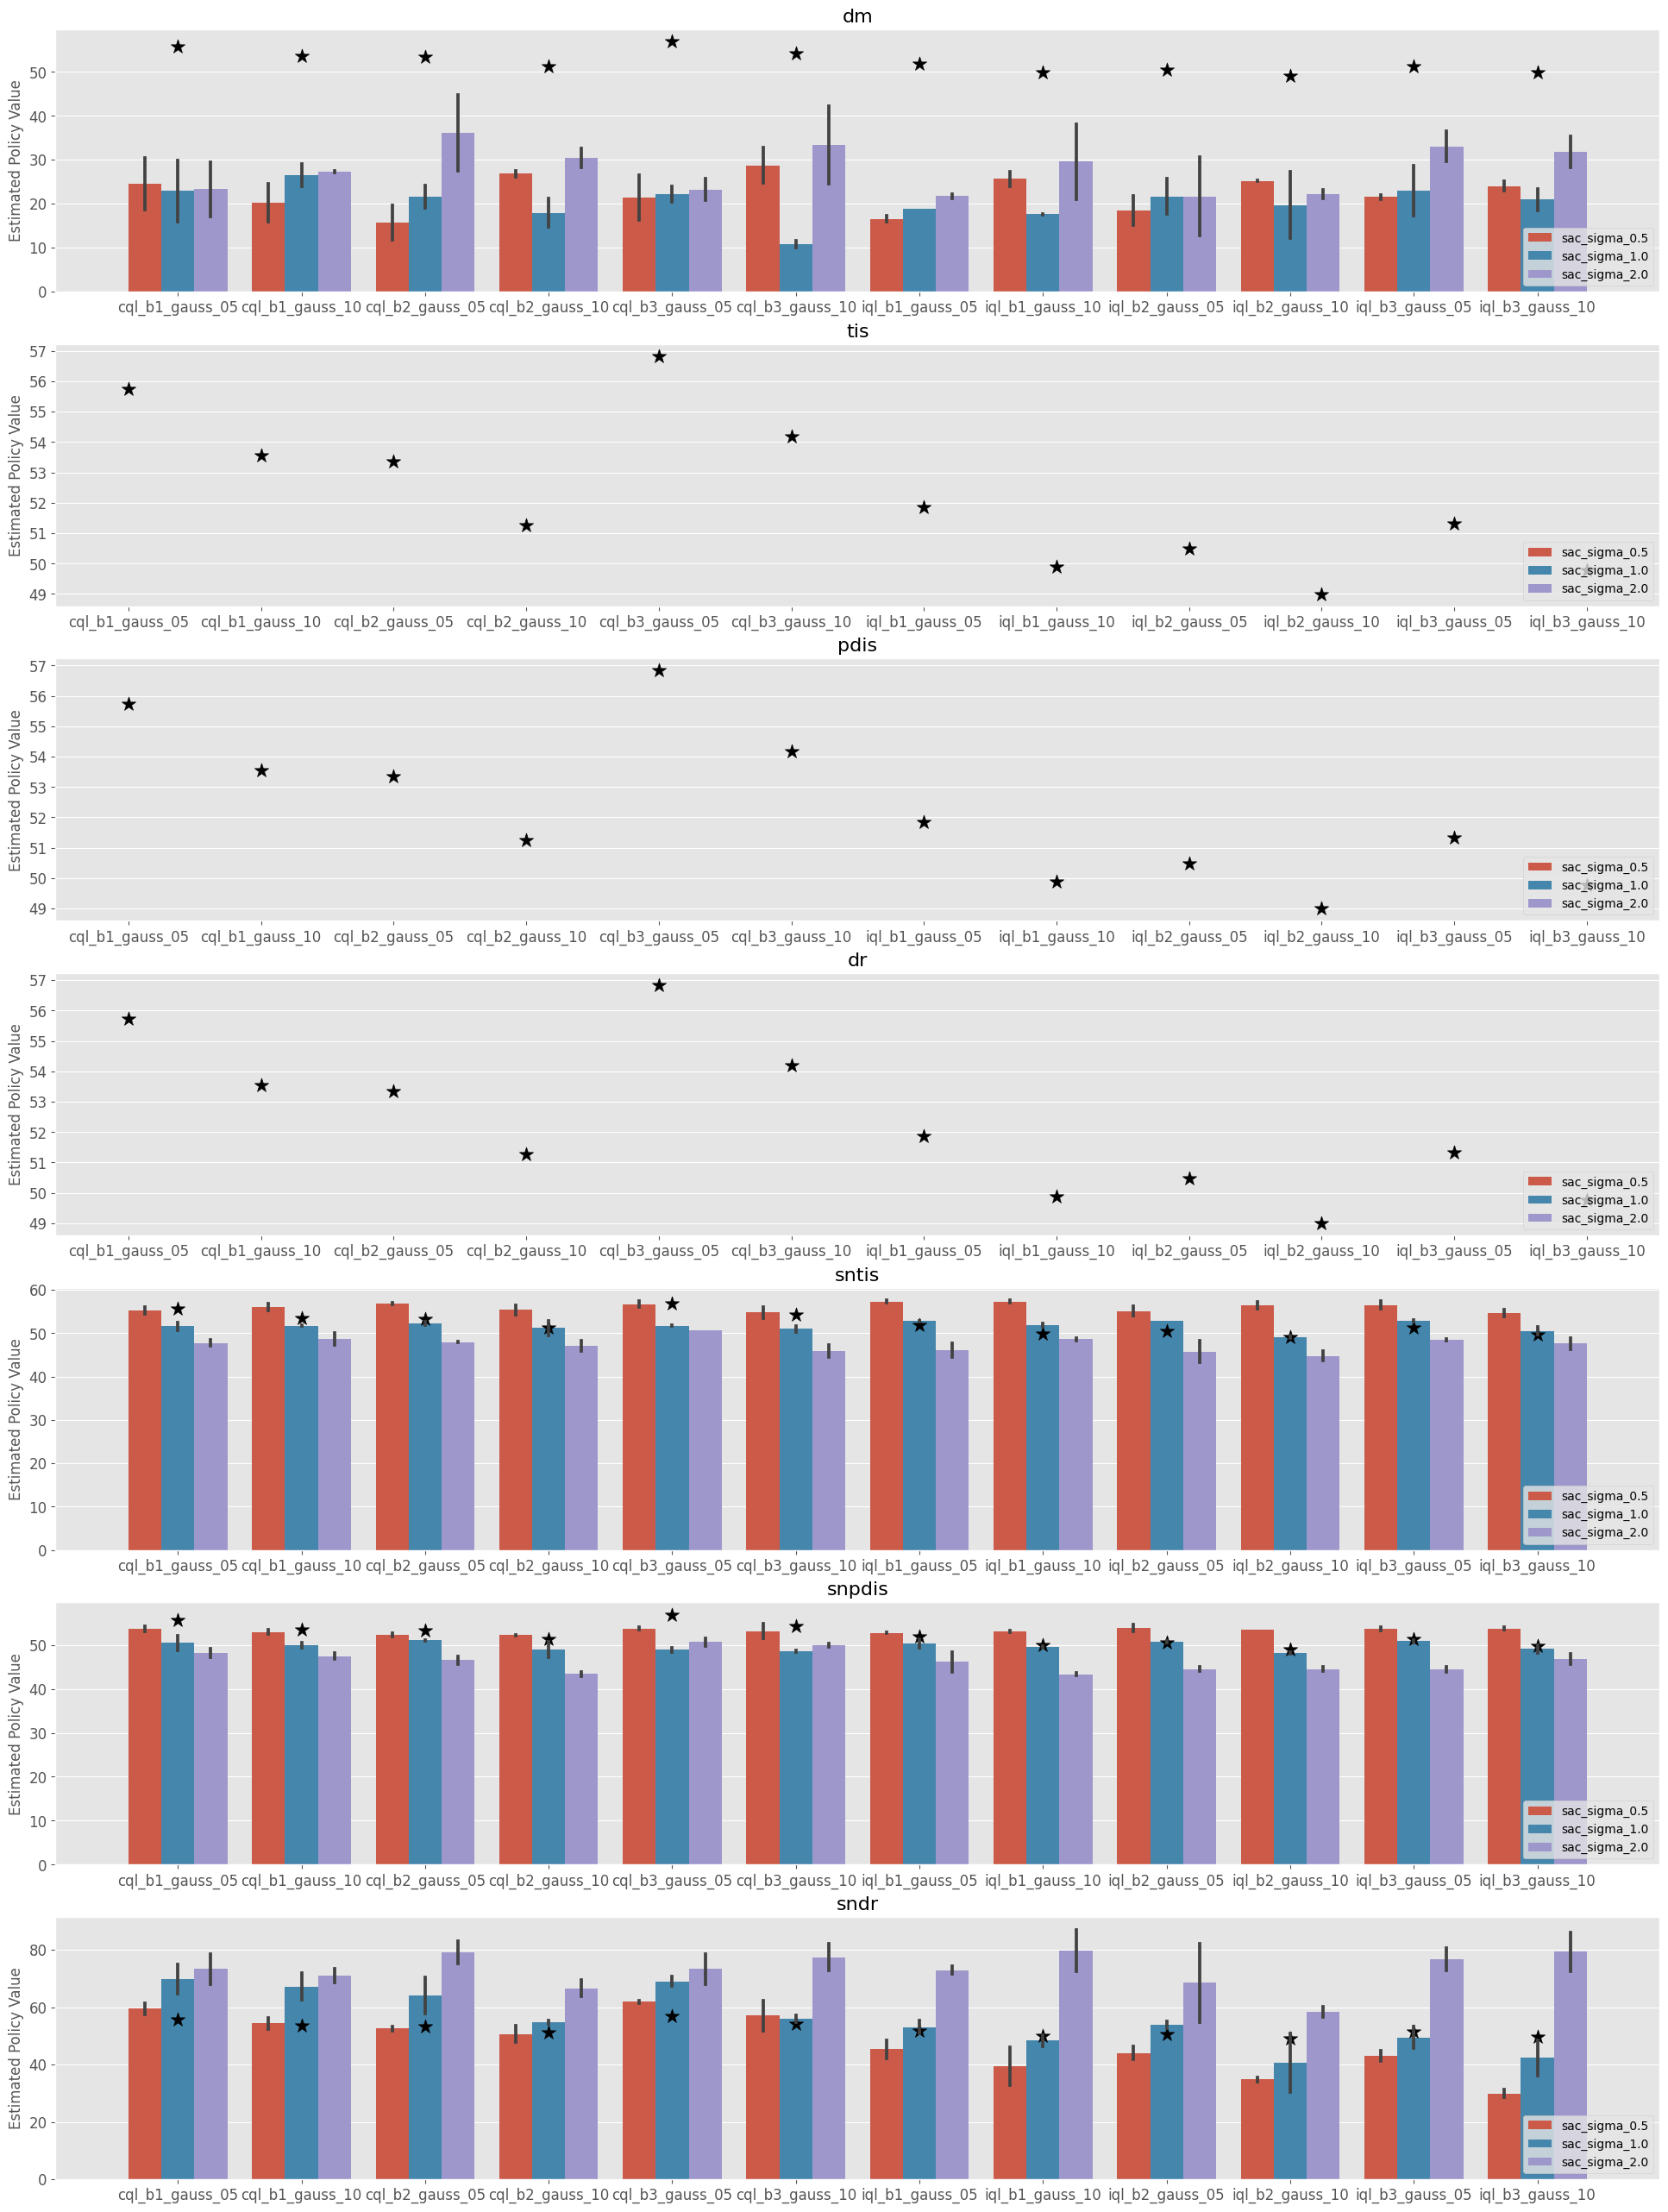

In [38]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

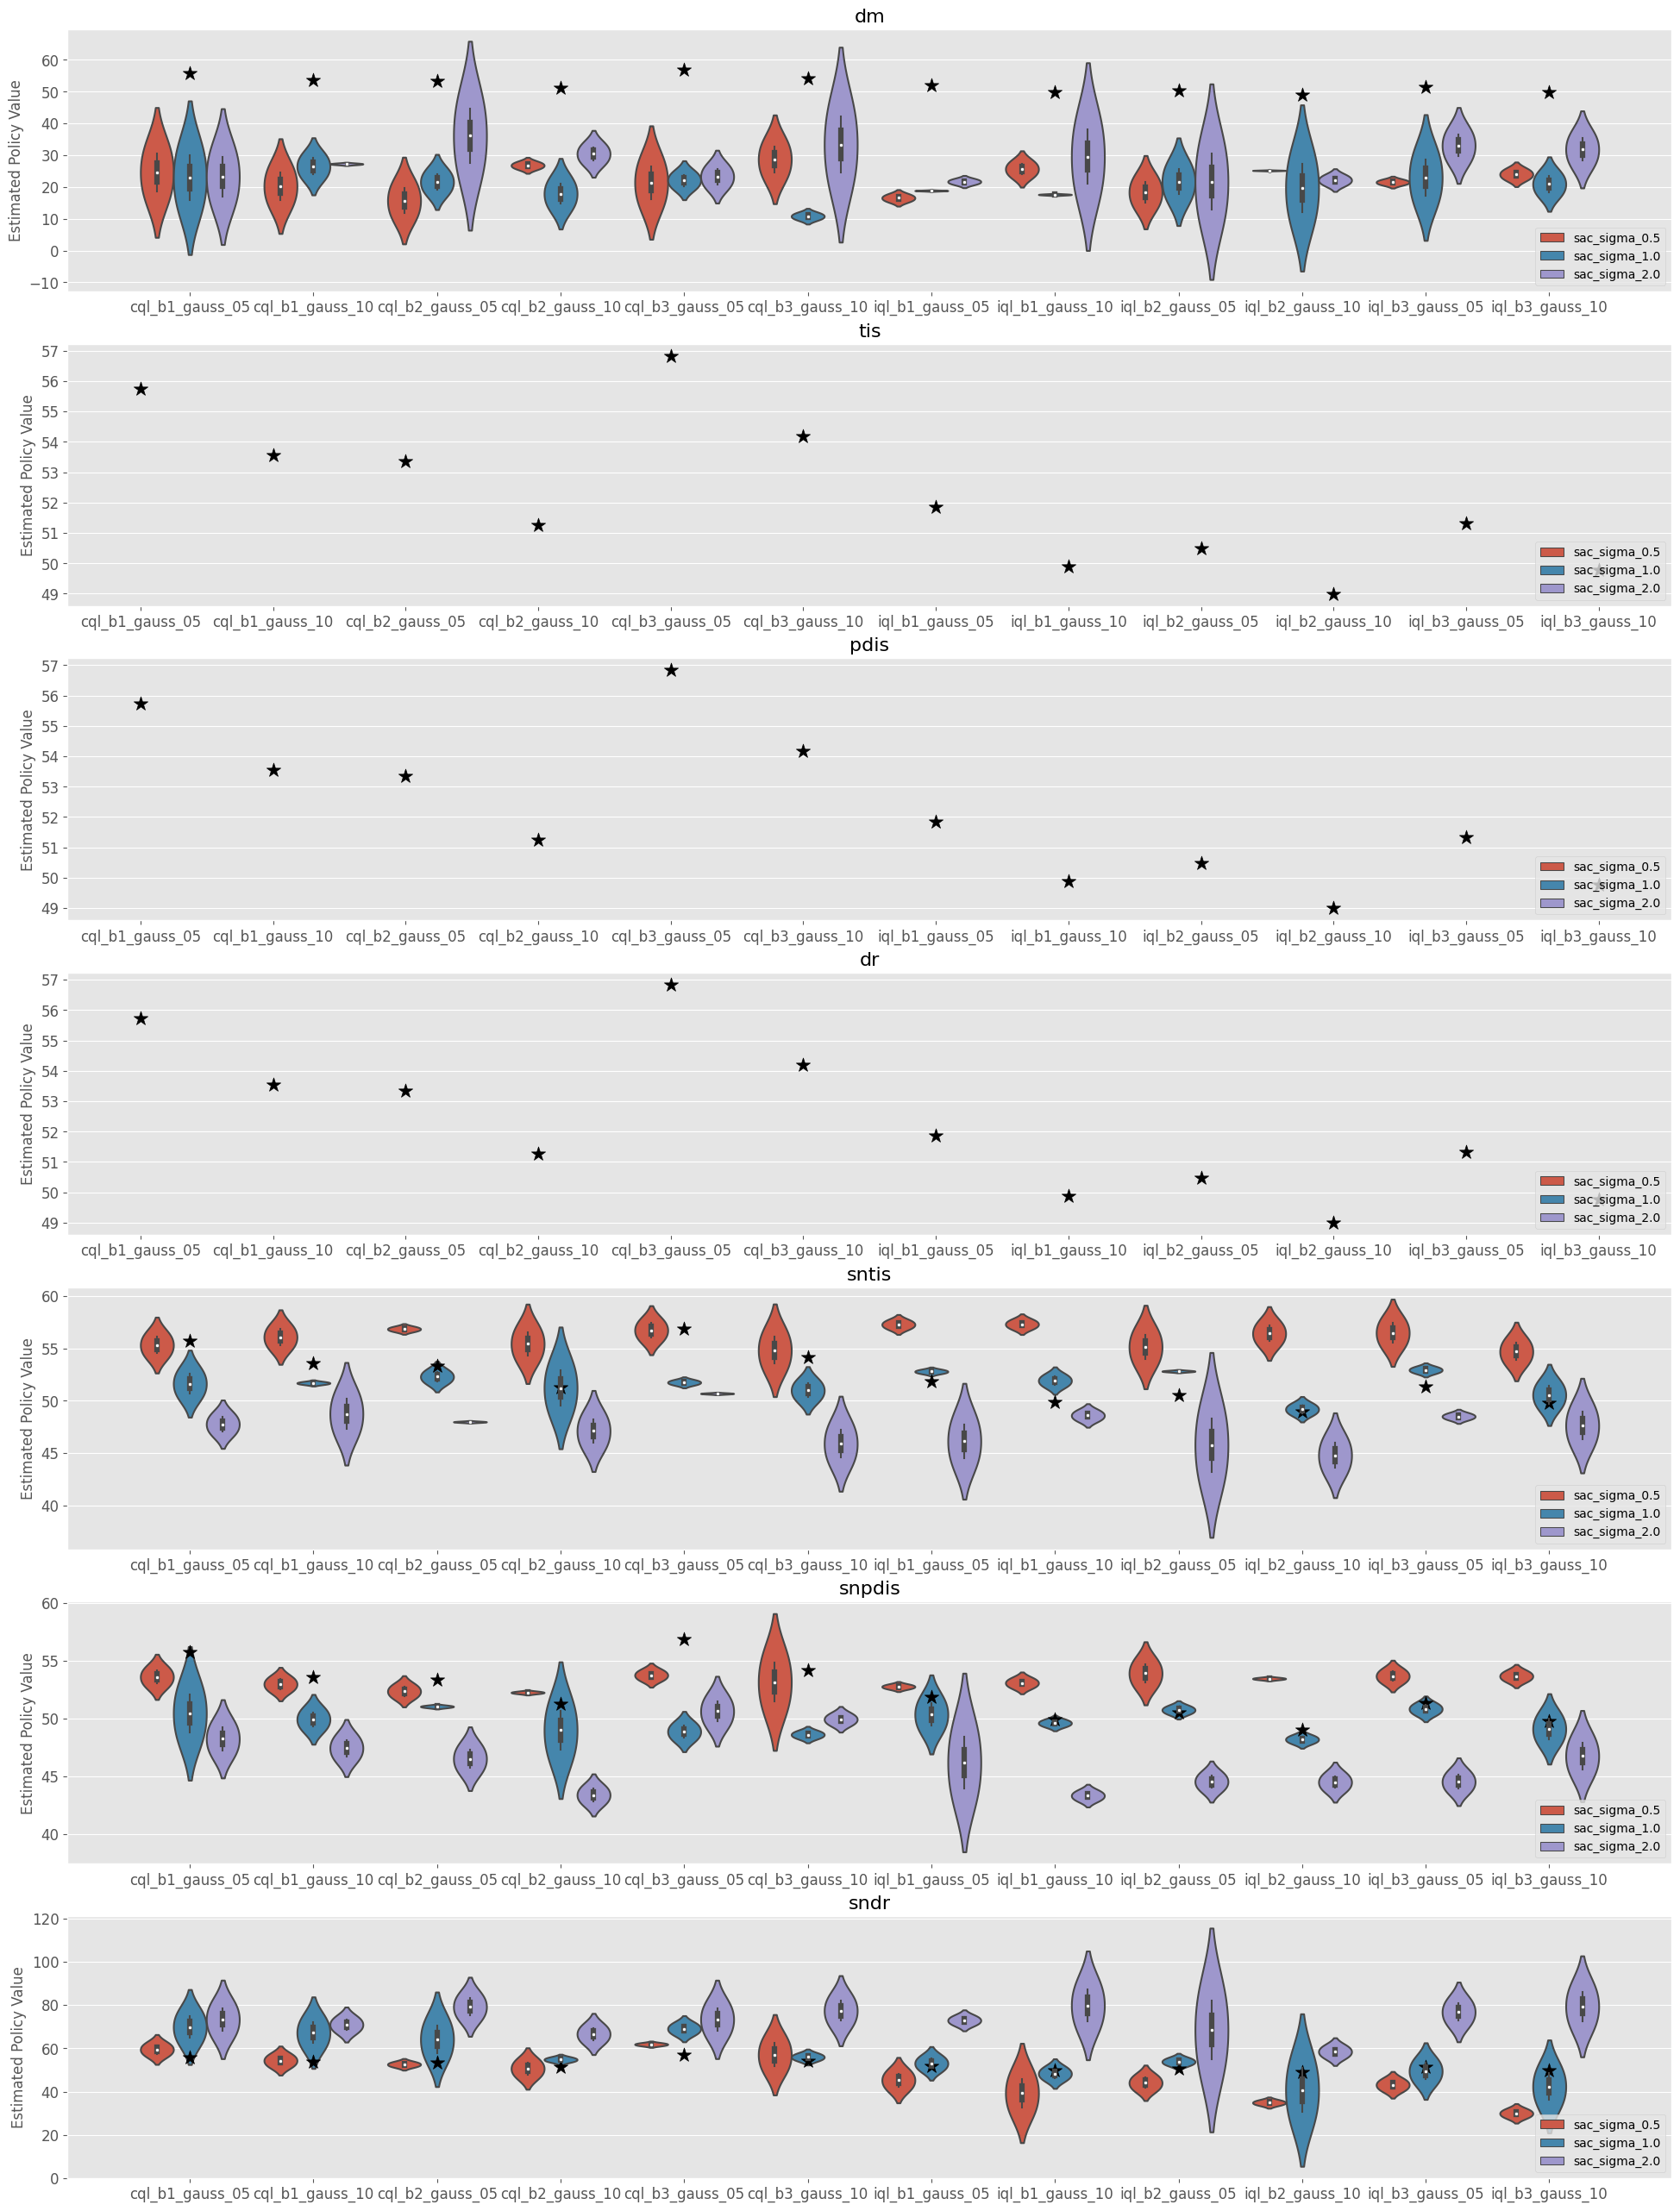

In [39]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

KeyError: 'y'

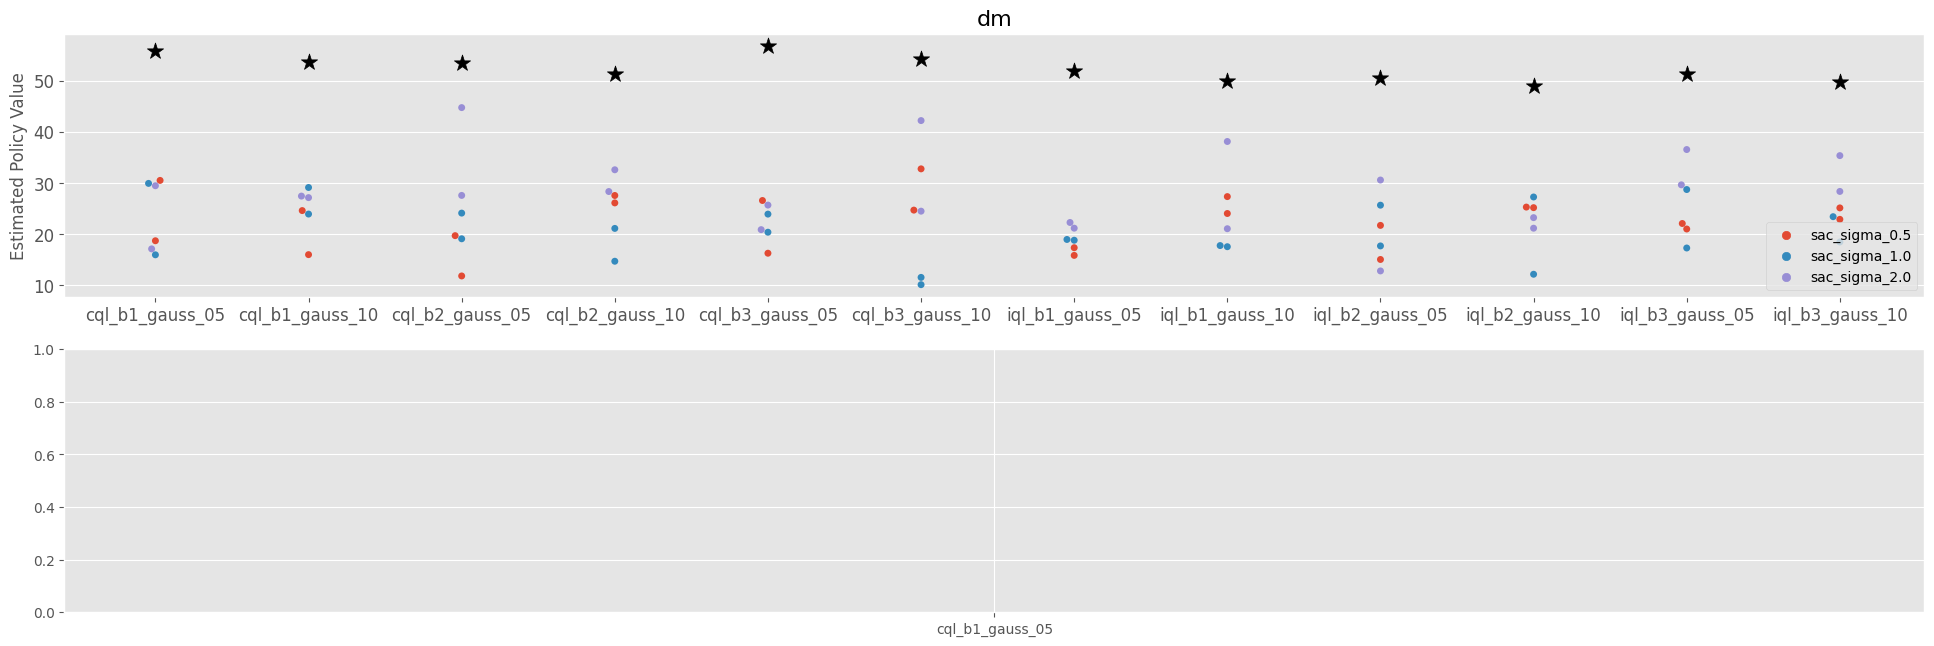

In [40]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [ ]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [ ]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

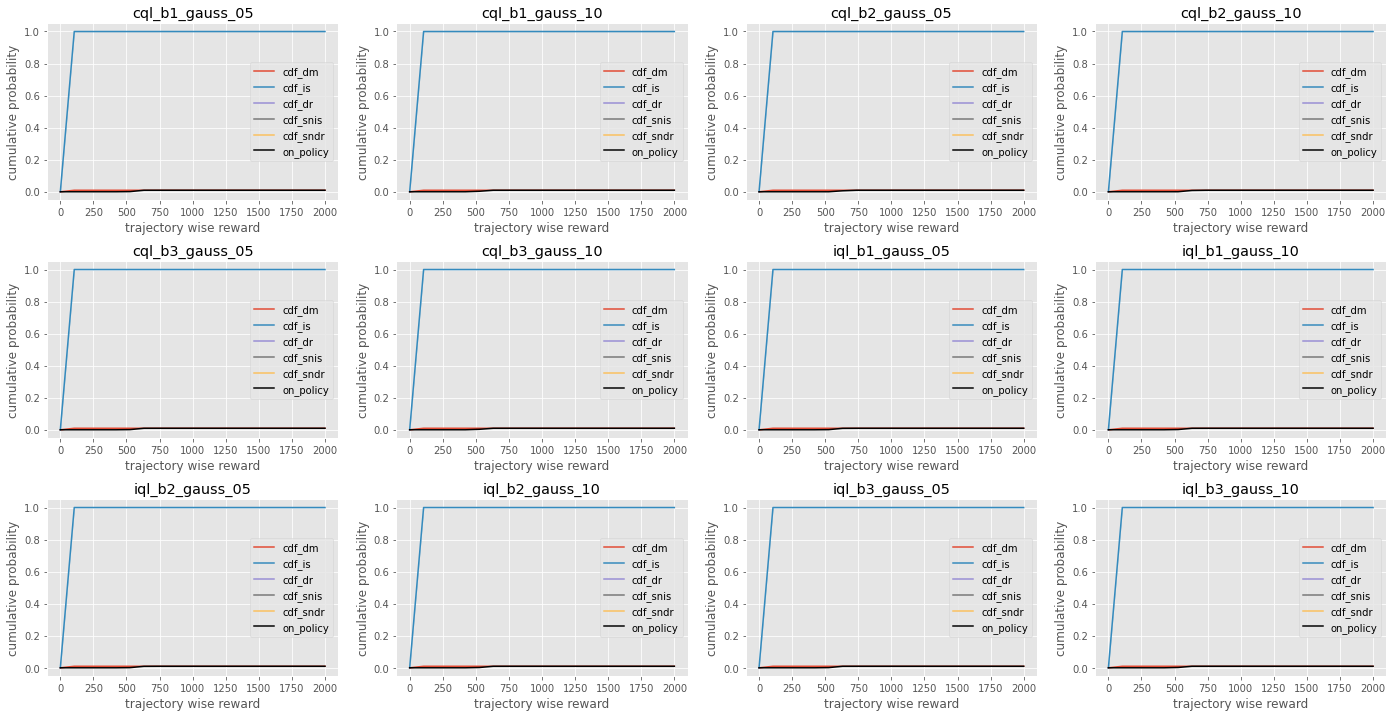

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
    n_cols=4,
)

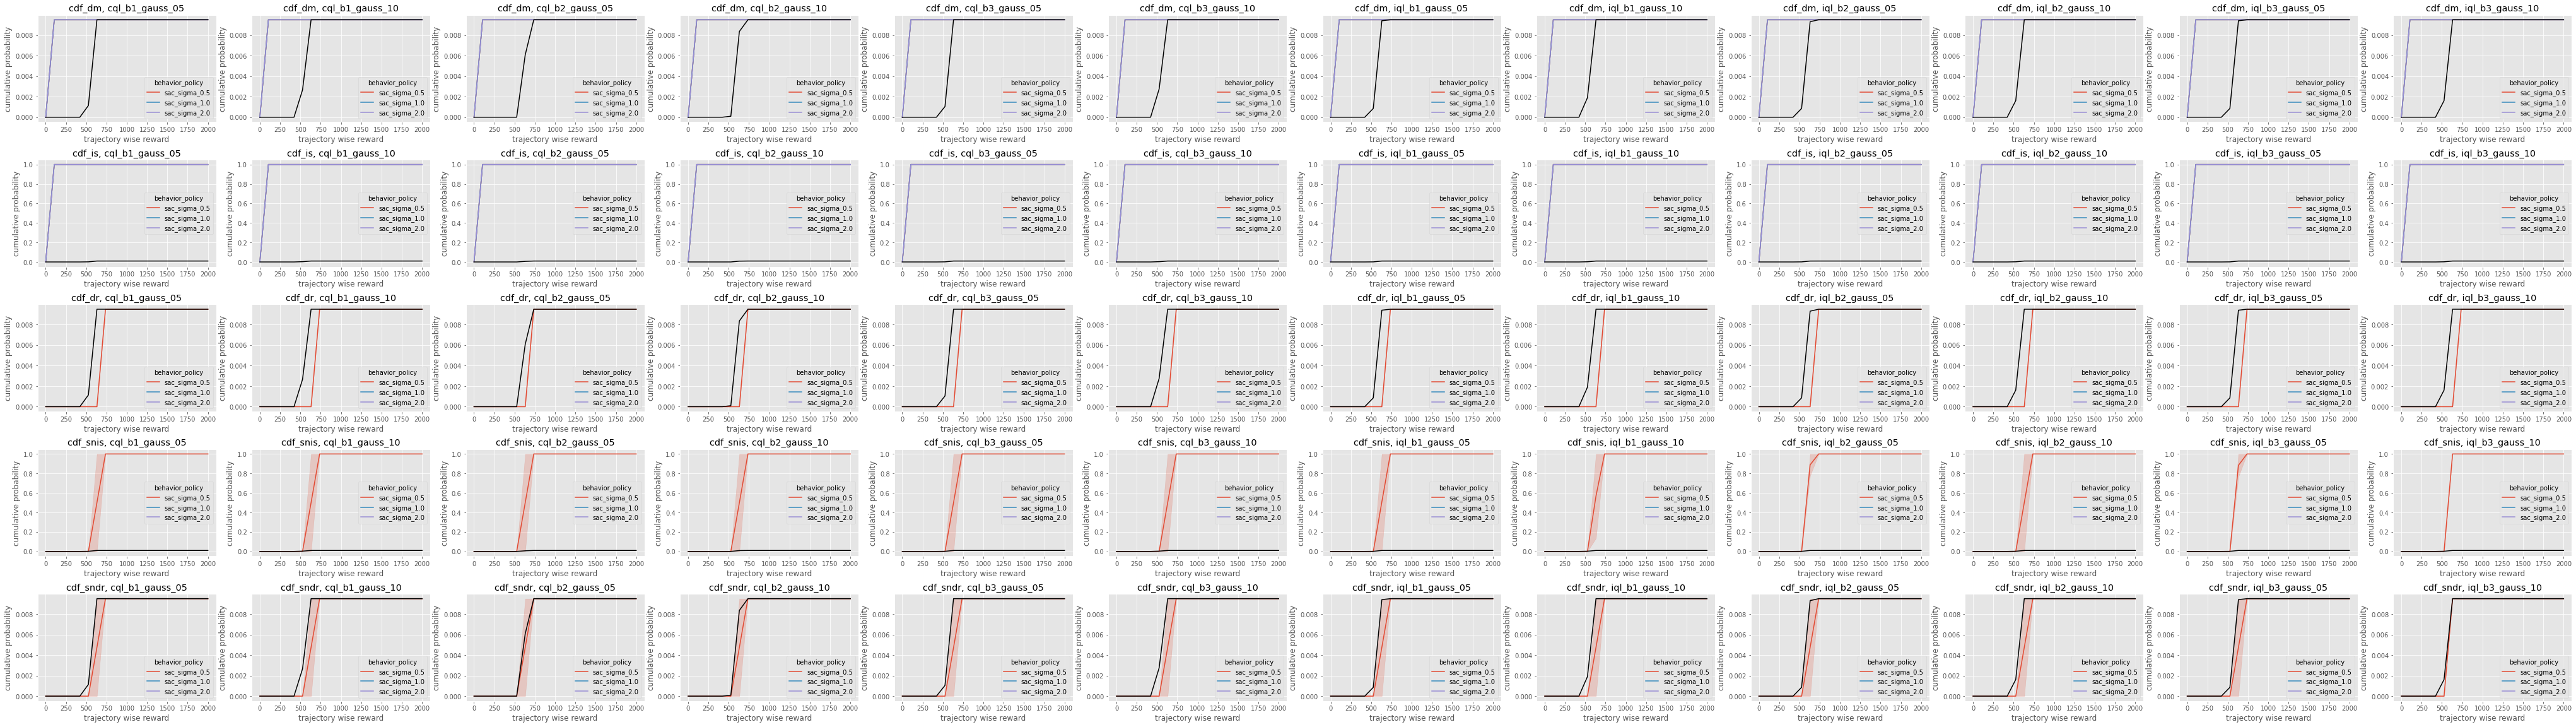

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

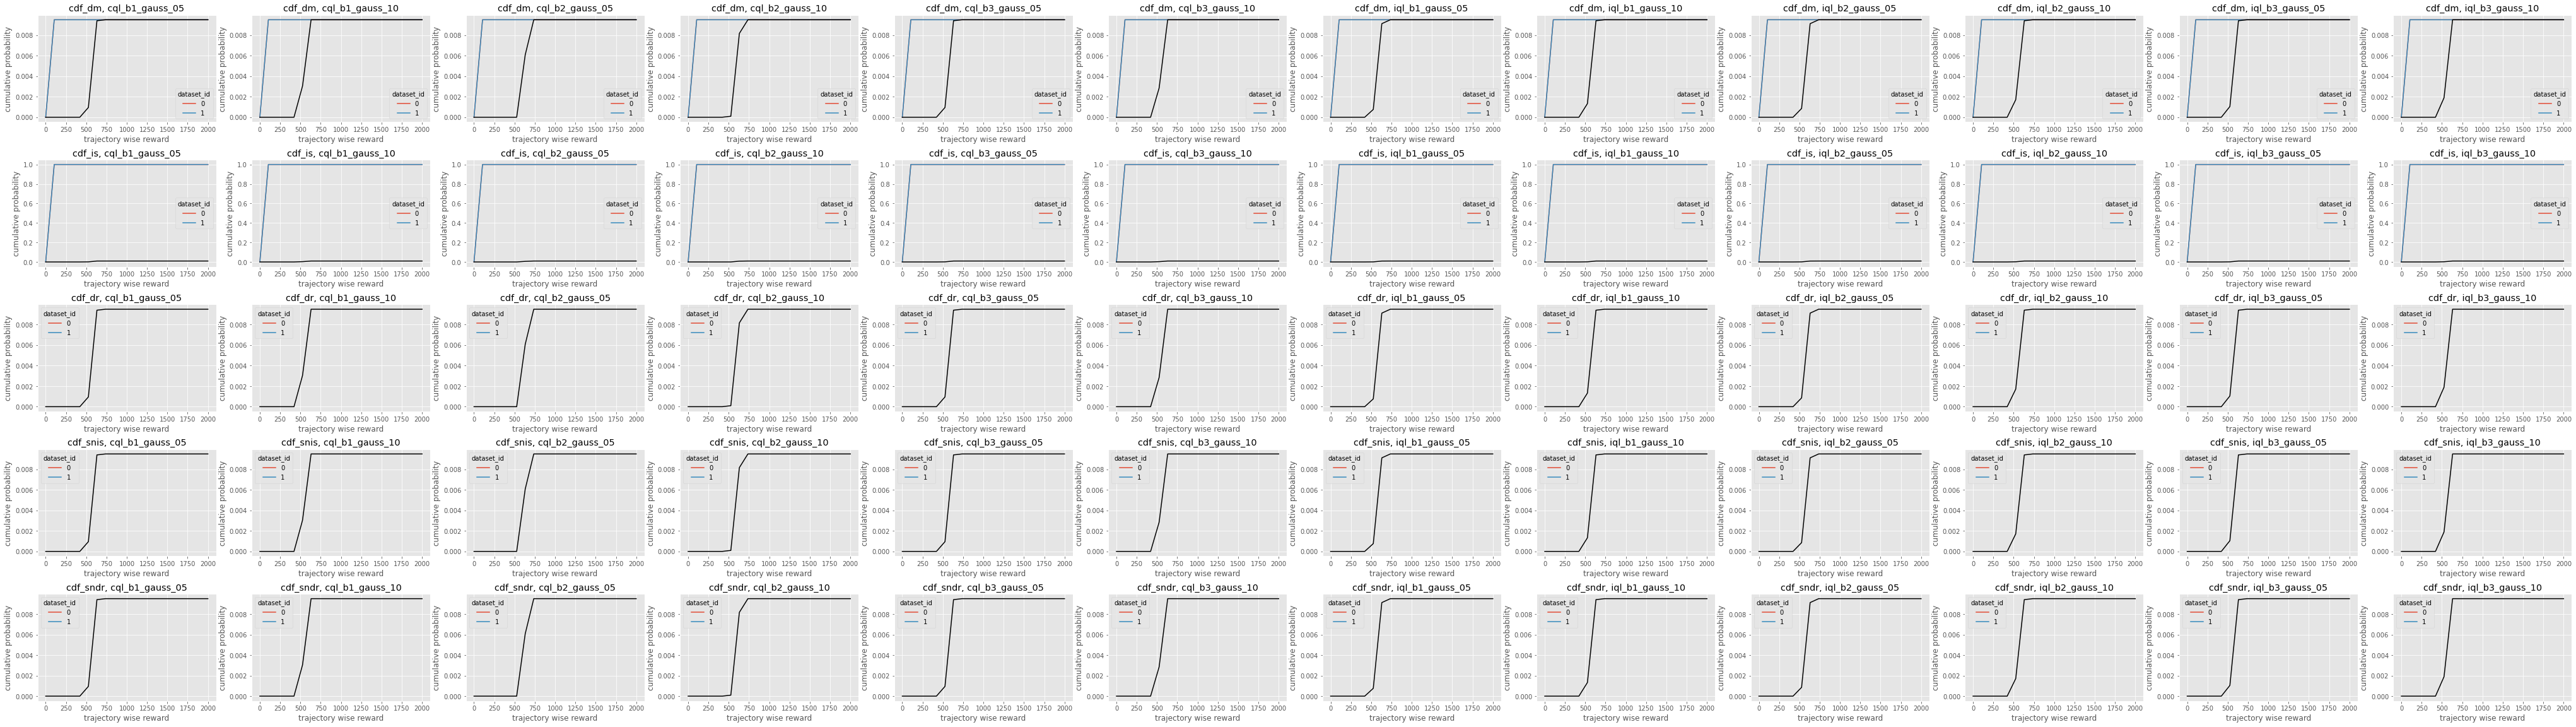

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

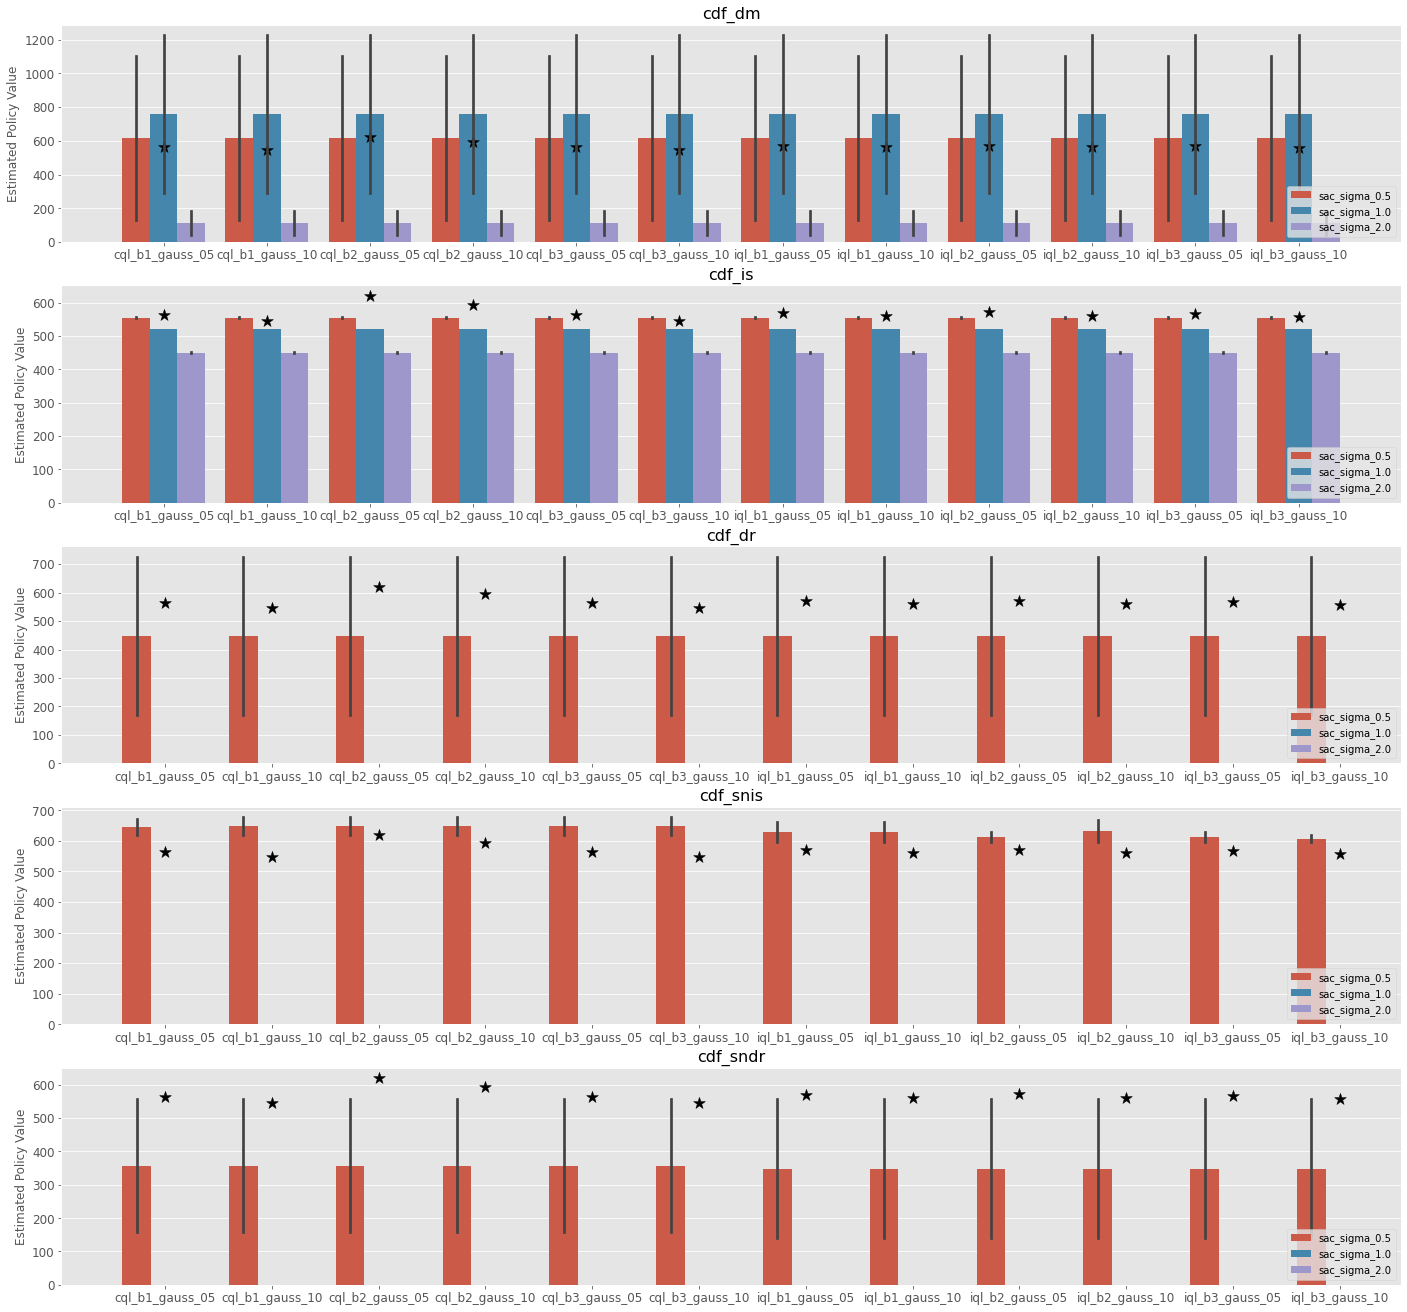

In [ ]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

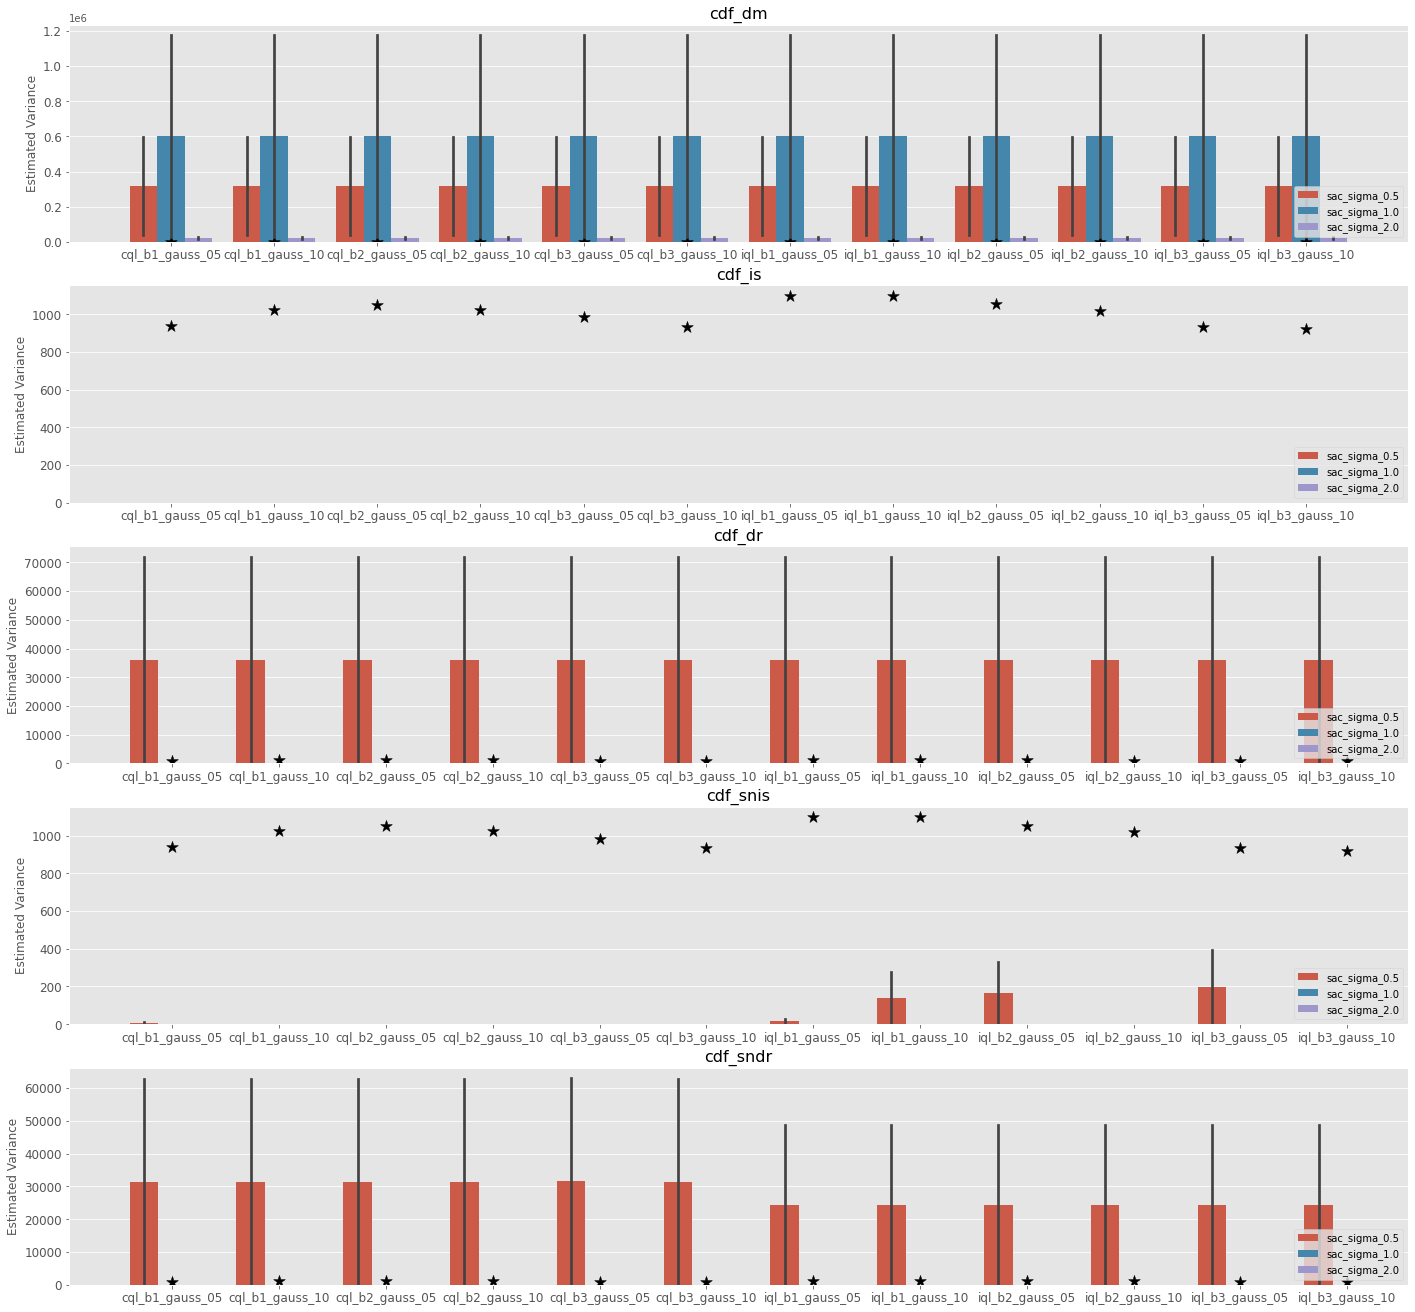

In [ ]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

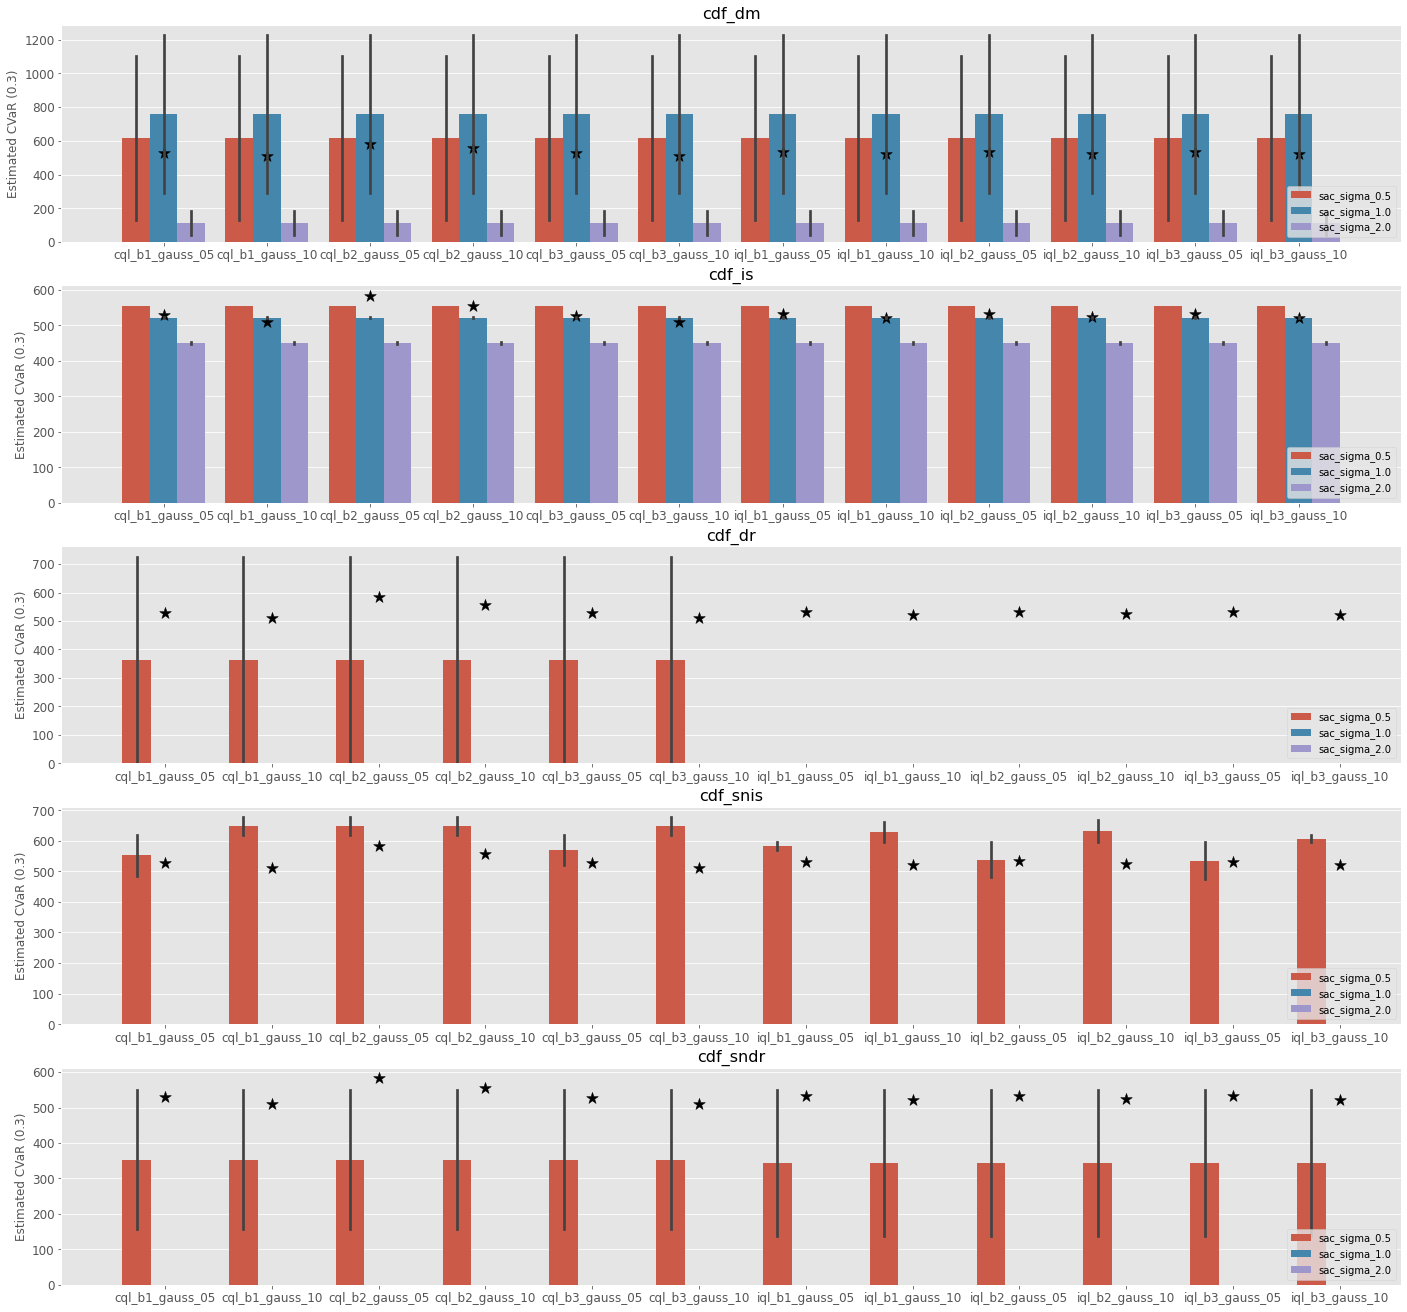

In [ ]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

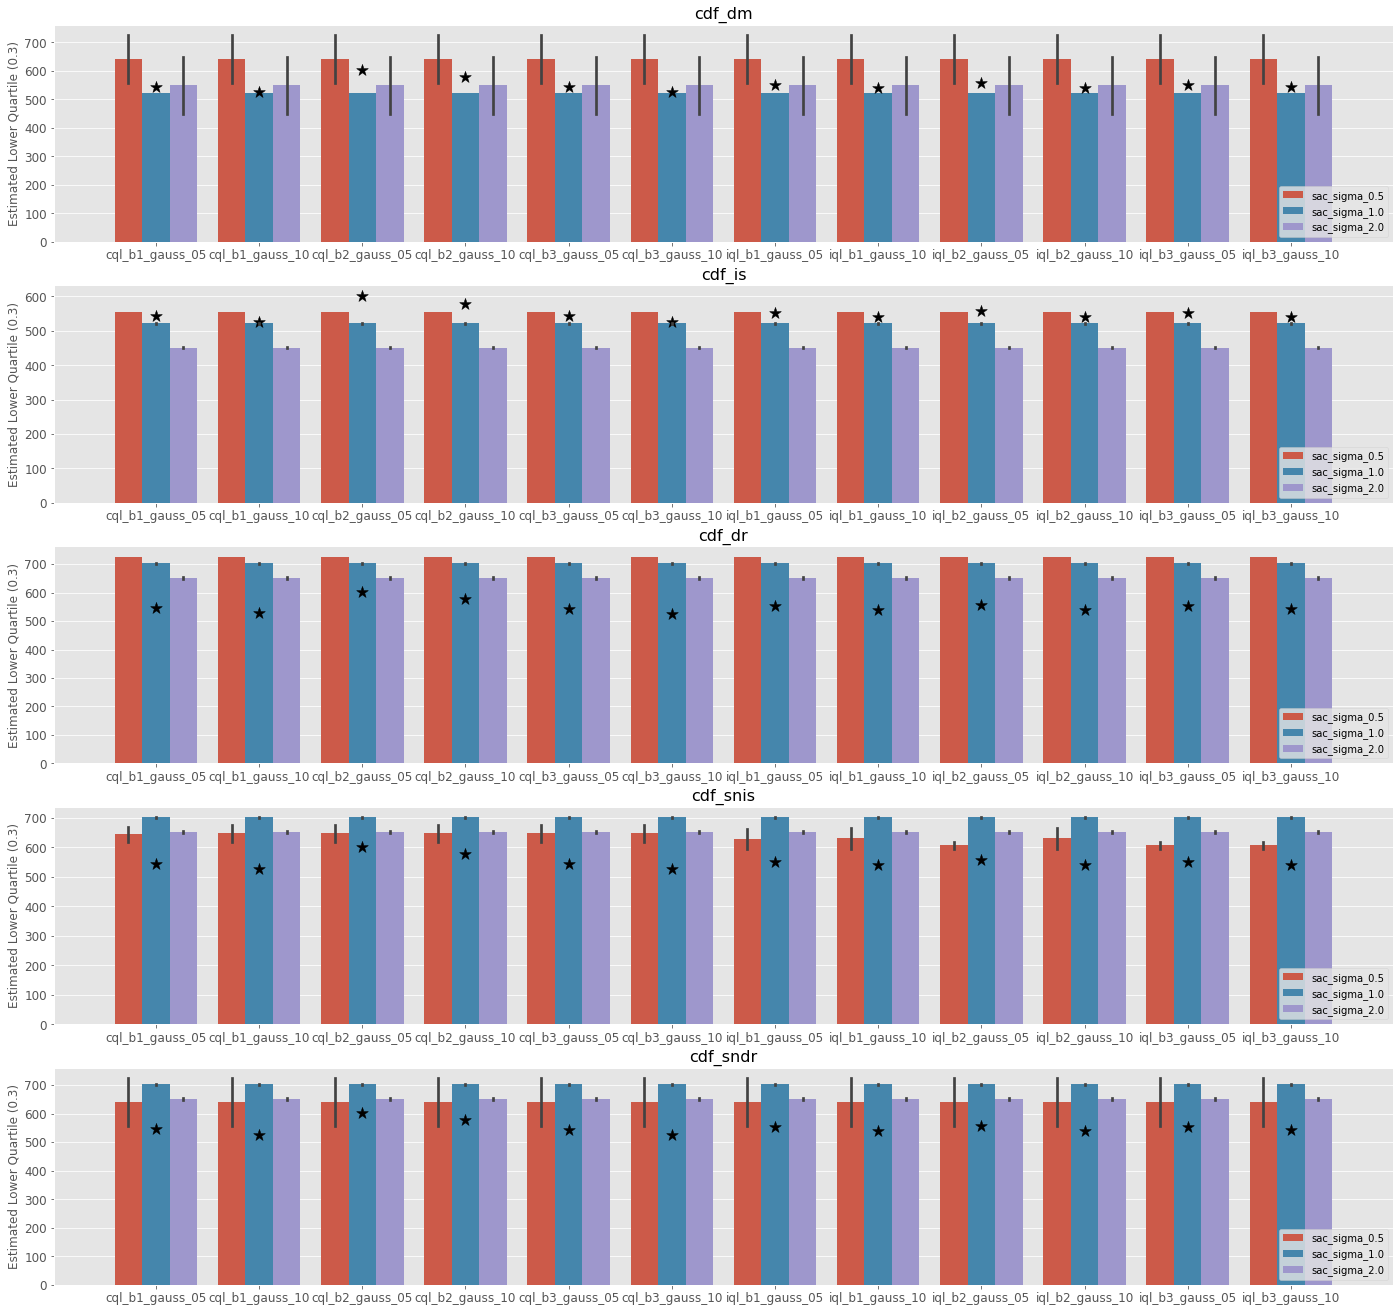

In [ ]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [ ]:
from ofrl.ope import OffPolicySelection

In [ ]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [ ]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

In [ ]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [ ]:
ranking_df[behavior_policies[0].name][0]

In [ ]:
metric_df[behavior_policies[0].name][0]

In [ ]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.